# Ising GNN

## Imports

In [3]:
%cd /Users/rodrigo/Post-Grad/Ising_GNN

/Users/rodrigo/Post-Grad/Ising_GNN


In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

In [5]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:


def create_graph(X_train, X_test, y_train, y_test, size=190 ,method={'knn' : 10}):
    
    train_data = []
    val_data = []

    # Creating train data in pyG DATA structure
    for i in range((X_train.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_train.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
        
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A

        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])

        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']


        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)
        
        train_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                               y=torch.tensor((y_train.iloc[i]))))

          
    # Creating test data in pyG DATA structure
    for i in range((X_test.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = reconstruct_symmetric_matrix(size,X_test.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
                
        Adj = torch.from_numpy(Adj).float()
        
        if method == None:
            A = A   
        
        elif list(method.keys())[0] =='knn':
            # Using k-NN to define Edges
            A = compute_KNN_graph(A, method['knn'])
            
        elif list(method.keys())[0] =='threshold':
            A[A < method['threshold']] = 0
            Adj[Adj < method['threshold']] = 0
            
        elif list(method.keys())[0] == 'knn_group':
            A = method['knn_group']
          
        
        # Removing self connections
        np.fill_diagonal(A,0)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index_A, edge_attr_A = dense_to_sparse(A)

        val_data.append(Data(x=Adj, edge_index=edge_index_A,edge_attr=edge_attr_A.reshape(len(edge_attr_A), 1),
                             y=torch.tensor((y_test.iloc[i]))))

    return train_data,val_data

## 2D Ising model simulation by MCMC

### $$E = -J\sum_{ij}^{N} \sigma_i \sigma_j; \quad P(\sigma_i flip | \Delta E > 0)= e^{-\beta \Delta E}; \quad P(\sigma_i flip | \Delta E < 0) = 1$$ $$; \quad \beta = \frac{1}{kT}$$

In [7]:
# Random initial state
def initial_state(L,string):
    if string == "aligned":
            state = np.full((L,L), 1,dtype=float)
    elif string == "random":
        state = 2 * np.random.randint(2, size=(L,L)) - 1
    else:
        return print("write aligned or random")
    return state

In [8]:
# Total energy calculation
@jit(nopython=True,fastmath=True,nogil=True)
def Total_Energy(config, J):
    L = len(config)
    total_energy = 0
    for i in range(L):
        for j in range(L):
            S = config[i,j]
            nb = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L]
            total_energy += -nb * S
    return (J*total_energy/4) # we need to take of the repeated spins that we counted

In [9]:
# Monte Carlo algorithm 
@jit(nopython=True,fastmath=True,nogil=True)
def MC_met(config,beta,J):
    L = len(config)
    a = np.random.randint(0, L)
    b = np.random.randint(0, L)
    sigma =  config[a, b]
    neighbors = config[(a+1)%L, b] + config[a, (b+1)%L] + config[(a-1)%L, b] + config[a, (b-1)%L]
    del_E = 2*sigma*neighbors
    if del_E < 0:
        sigma *= -1
    elif np.random.rand() < np.exp(-del_E*beta):
        sigma *= -1
    config[a, b] = sigma
    return config

In [10]:
# Order Parameter
@jit(nopython=True,fastmath=True,parallel=True)
def mag(config):
    return np.sum(config)

In [11]:
@jit(nopython=True,fastmath=True,nogil=True)
def temporalseries(T,config,iterations,iterations_fluc,fluctuations,J,n):

    temporal_series = np.zeros((fluctuations,n,n))
    mag_data = np.zeros(fluctuations)
    ene_data = np.zeros(fluctuations)
    beta = 1/T
    
    #thermal equilibrium
    for i in range(iterations):
        #if i % 1000000 == 0:
            #print(i/iterations)
        config = MC_met(config,beta, J)
        
    for z in range(fluctuations):
        
        for i in range(iterations_fluc):
            config = MC_met(config,beta,J)

        temporal_series[z] = config
        ene_data[z] = Total_Energy(config, J) 
        mag_data[z] = mag(config)  
        
    return temporal_series, ene_data, mag_data

In [12]:
# Matrix containing all the system states
#@jit(nopython=True,fastmath=True,nogil=True)
def Matrix_X(Temps,config,iterations,J,n, block_size):
    
    fluctuations = 200

    X = np.zeros((len(Temps), int((n//block_size)**4)))#,int(((n)//block_size*block_size)**2)))

    for t in range(len(Temps)):
        print('Models ', t + 1, end="\r",flush=True)
        #if t%100 == 0:
            #print('Models ', t, end="\r",flush=True)
            #print('Temp ',Temps[t], end="\r",flush=True)

        model = temporalseries(Temps[t], config, iterations, n*n, fluctuations, J, n)
        avg_model = average_blocks(model, block_size)

        avg_model_df = pd.DataFrame(avg_model.reshape(fluctuations,avg_model.shape[1]*avg_model.shape[1]))
        #avg_model_df = avg_model_df#.diff(1).dropna()
        corr_matrix = (pd.DataFrame(avg_model_df).corr()).replace(1,0)#*10
        
        X[t,:] = corr_matrix.values.reshape(1,corr_matrix.shape[1]*corr_matrix.shape[1])
    

    return  X



In [13]:
def average_blocks(model, block_size):
    time_series_size = len(model[0][:,0,0]) 
    avg_model = np.zeros((time_series_size,int(len(model[0][1])/block_size),int(len(model[0][1])/block_size)))

    for t in range(time_series_size):
        for i in range(0,(len(model[0][0]) - block_size + 1),block_size):
            for j in range(0, (len(model[0][0]) - block_size + 1),block_size):
                l_0 = block_size
                avg_model[t][i//block_size, j//block_size] = np.mean(model[0][t][i:(i+l_0),j:(j+l_0)])
    return avg_model

In [14]:
@jit(nopython=True, fastmath=True, nogil=True)
def corr_net(temporal_series):
    
    steps = len(temporal_series)
    spins = len(temporal_series[0])**2
    
    temporal_series_linear = temporal_series.reshape((steps*spins ))
    
    corr_array = np.array([0.0])
    xi = np.zeros(steps)
    xj = np.zeros(steps)
    for i in range(spins):
        corr = np.zeros(spins - (i+1))
        for j in range(i+1,spins):
            for n in range(steps):
                xi[n] = temporal_series_linear[i + n*spins]
                xj[n] = temporal_series_linear[j + n*spins]

            diff_i = list()
            diff_j = list()
            for a in range(1, len(xi)):
                value_i = xi[a] - xi[a - 1]
                value_j = xj[a] - xj[a - 1]
                diff_i.append(value_i)
                diff_j.append(value_j)
            corr[j - (i+1)] = float(np.corrcoef(diff_i,diff_j)[0,1])

            #corr[j - (i+1)] = float(np.corrcoef(xi,xj)[0,1])
        corr_array = np.concatenate((corr_array,corr))
        
    return corr_array

## Experimental setup

# TESTAR SE QUALQUER MA
TRIX COM DIST NORMAL SEGUE O PADRÃO

In [15]:
330//23

14

#### fluctuations. increase iterations between time series points

In [16]:
J = 1     # J
n = 330    # Lattice size
iterations = ((n*n)*n)*30    # Iterations to thermal equilibrium
T_1 = np.linspace(1.6,2.21,400)
T_2 = np.linspace(2.21,2.35,800)
#T_3 = np.linspace(2.5,4,100)
Temps = np.hstack((T_1,T_2)).ravel()#,T_3 )).ravel()



In [38]:
config = initial_state(n,"random")


X = Matrix_X(Temps, config,iterations,J,n,23)

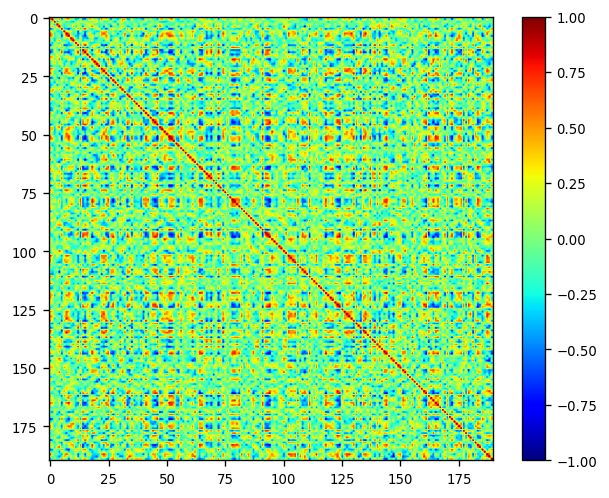

In [24]:
plt.figure(dpi=120)
plt.imshow(reconstruct_symmetric_matrix(190, X[732,:]), cmap='jet',vmin=-1, vmax=1)
plt.colorbar()

In [37]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=300)

# ax1.imshow(X[1,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet', vmin=-1, vmax=1)#, cmap='Greys')
# ax2.imshow(X[100,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet',vmin=-1, vmax=1)#, cmap='Greys')
# ax3.imshow(X[-1,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))), cmap='jet',vmin=-1, vmax=1)#, cmap='Greys')

# for i in [ax1,ax2,ax3]:
#     i.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)

# plt.show()

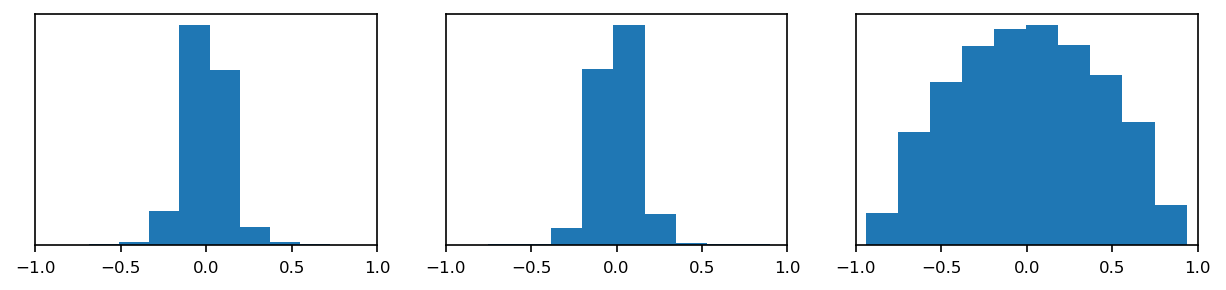

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=150,figsize=(10,2))

ax1.hist(X[0,:])#, cmap='Greys')
ax1.set_xlim(-1,1)
ax2.hist(X[4,:])#, cmap='Greys')
ax2.set_xlim(-1,1)
ax3.hist(X[-1,:])#, cmap='Greys')
ax3.set_xlim(-1,1)

for i in [ax1,ax2,ax3]:
    i.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)

plt.show()

In [39]:
def upper_triangle_array(df):
    #df = df.astype(float)
    matrix = df
    result = matrix[np.triu_indices_from(matrix,1)]
    return result.reshape(1,len(result))

In [40]:
X_aux = X.copy()

In [41]:

X_aux = X_aux[:,:].reshape(X.shape[0],int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1])))[:,3:-3,3:-3]
X_aux.shape

ValueError: cannot reshape array of size 21546000 into shape (1200,133,133)

In [42]:
X = np.zeros((X.shape[0], int((190*190 - 190)/2)))
for i in range(X.shape[0]):
    X[i,:] = upper_triangle_array(X_aux[i,:].reshape(190,190))
    
    

# X = np.zeros(( X.shape[0] , int((int(np.sqrt(X.shape[1]))*int(np.sqrt(X.shape[1])) - int(np.sqrt(X.shape[1])))/2)))
# for i in range(X.shape[0]):
#     X[i,:] = upper_triangle_array(X_aux[i,:].reshape(int(np.sqrt(X.shape[1])),int(np.sqrt(X.shape[1]))))

ValueError: cannot reshape array of size 17955 into shape (190,190)

In [15]:
X = np.loadtxt('Ising_GNN.txt').reshape(1200,17955)

In [16]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X),pd.DataFrame(Temps),test_size=0.15, shuffle=True, random_state=42)

In [17]:
A = reconstruct_symmetric_matrix(190,X_train.iloc[420,:])#.mean(axis=0))

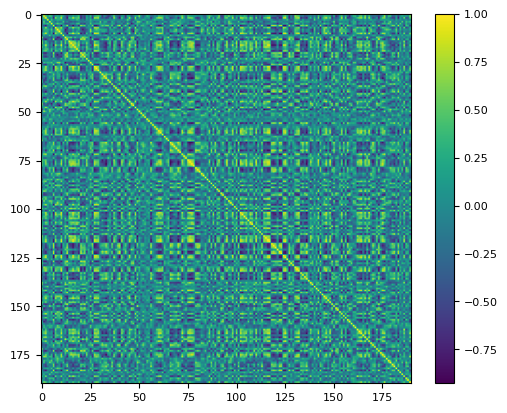

In [18]:
plt.imshow(A)
plt.colorbar()
plt.show()

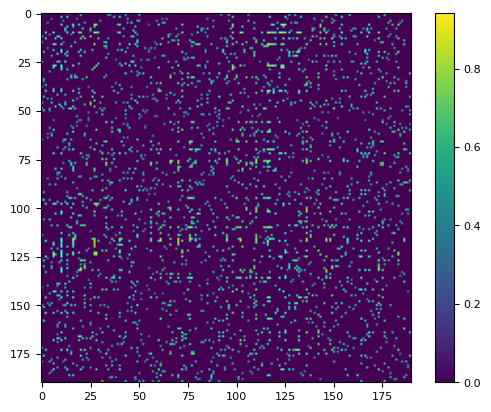

In [19]:
plt.imshow(np.array(compute_KNN_graph(A, 10)))
plt.colorbar()
plt.grid(False)
plt.show()

In [20]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test,size=190)

#train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST) #,method={'threshold': 0.2})

In [21]:
print(train_data[0])

Data(x=[190, 190], edge_index=[2, 2762], edge_attr=[2762, 1], y=[1])


In [37]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=64)


In [38]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool
from torch_geometric.nn import aggr


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.4):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(100,64)
        
        #self.gat1 = GATv2Conv(int(num_features), 148, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(148*6, 100, heads=1)
        #self.gat3 = GATv2Conv(100*2, 64, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 128, K=k_order)
        self.conv2 = ChebConv(128, 128, K=k_order)
        self.conv3 = ChebConv(128, 80, K=k_order)


        self.lin1 = torch.nn.Linear(80, 16)
        self.lin2 = torch.nn.Linear(16, 1)

        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        
        self.pool = global_mean_pool
        
        self.aggregation = aggr.SoftmaxAggregation()

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = torch.nn.functional.leaky_relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        x = torch.nn.functional.leaky_relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat2(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn2(x)
        x = torch.nn.functional.leaky_relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn3(x)
        
        x = self.pool(x, batch)
        #x = self.aggregation(x, batch)
        x1 = self.lin1(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        x2 = self.lin2(x1)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return (x1,x2)

In [39]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[1]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)

    return mae, mse, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    loss = nn.MSELoss()
    l1_weight = 0
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)[1]
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (y.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
        
    return mae, mse, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 0
    loss = nn.MSELoss()
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[1]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss_value = loss(output.squeeze(), (data.y).float())
        loss_with_penalty = loss_value + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(output)
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    mae = mean_absolute_error(y_pred,y_true)
    mse = mean_squared_error(y_pred, y_true)
    
    return mae,mse, loss_all / len(val_data)


In [40]:
metrics = {"loss_train" : [], "loss_test" : [], "mae_test" : [], "mae_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=.1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
 #model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 240

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_mae, train_mse, train_loss = GCN_train(train_loader,loop)
    test_mae, test_mse, test_loss = GCN_test(val_loader)
    TRAIN_mae, TRAIN_mse, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    #scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['mae_test'].append(test_mae)
    metrics['mae_train'].append(TRAIN_mae)
    
    print('Val MAE {} , Val Loss {}'.format(test_mae, test_loss))
    print('Train MAE {} , Train Loss {}'.format(TRAIN_mae, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/240]: 100%|█████████████████| 16/16 [00:09<00:00,  1.70it/s, loss=2.69]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 1.400466129330608 , Val Loss 1.9726163354184894
Train MAE 1.3937535437916169 , Train Loss 1.954255103597454


Epoch [2/240]: 100%|██████████████████| 16/16 [00:08<00:00,  1.90it/s, loss=1.1]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.9468697519578664 , Val Loss 0.9305288920799891
Train MAE 0.9213365068947897 , Train Loss 0.8831718220430262


Epoch [3/240]: 100%|████████████████| 16/16 [00:08<00:00,  1.81it/s, loss=0.407]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.6467260415168068 , Val Loss 0.49092720957220687
Train MAE 0.6094817250027702 , Train Loss 0.44335836627904107


Epoch [4/240]: 100%|████████████████| 16/16 [00:07<00:00,  2.00it/s, loss=0.225]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.5190444695398463 , Val Loss 0.3516778225770395
Train MAE 0.4767198659634201 , Train Loss 0.3094170146128711


Epoch [5/240]: 100%|████████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.192]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.48018744139966874 , Val Loss 0.3084283378605
Train MAE 0.4359118631695619 , Train Loss 0.26928624744508783


Epoch [6/240]: 100%|████████████████| 16/16 [00:08<00:00,  1.87it/s, loss=0.189]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4673913392370238 , Val Loss 0.2941188554860774
Train MAE 0.4239746039133175 , Train Loss 0.256331903443617


Epoch [7/240]: 100%|████████████████| 16/16 [00:08<00:00,  1.88it/s, loss=0.184]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.46015287679991124 , Val Loss 0.2858918745580976
Train MAE 0.4173996131439599 , Train Loss 0.248979935575934


Epoch [8/240]: 100%|████████████████| 16/16 [00:08<00:00,  1.83it/s, loss=0.182]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4563279745568269 , Val Loss 0.28122272995254255
Train MAE 0.41394580797782765 , Train Loss 0.24487875758432875


Epoch [9/240]: 100%|█████████████████| 16/16 [00:08<00:00,  1.89it/s, loss=0.18]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.45327543459893266 , Val Loss 0.277387756659295
Train MAE 0.411189627845691 , Train Loss 0.24153145586743074


Epoch [10/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.93it/s, loss=0.177]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4500439714315302 , Val Loss 0.27340310110324867
Train MAE 0.4082670871763433 , Train Loss 0.23804602406772912


Epoch [11/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.90it/s, loss=0.175]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4472007802052067 , Val Loss 0.2698447972952664
Train MAE 0.40569501702652894 , Train Loss 0.23494581638597975


Epoch [12/240]: 100%|███████████████| 16/16 [00:13<00:00,  1.21it/s, loss=0.174]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4444888452303371 , Val Loss 0.26643991936091205
Train MAE 0.4032403730524117 , Train Loss 0.23198627806177327


Epoch [13/240]: 100%|████████████████| 16/16 [00:08<00:00,  1.80it/s, loss=0.17]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4412982145559749 , Val Loss 0.2626017512007201
Train MAE 0.40035866717458407 , Train Loss 0.22862776564616782


Epoch [14/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.80it/s, loss=0.167]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4386647224040787 , Val Loss 0.25934132301056
Train MAE 0.3979737817886594 , Train Loss 0.225793197926353


Epoch [15/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.63it/s, loss=0.165]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.43595715359965576 , Val Loss 0.2560372620144941
Train MAE 0.39552508317085633 , Train Loss 0.2229182577600666


Epoch [16/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.86it/s, loss=0.164]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.43352402908391036 , Val Loss 0.253022456670068
Train MAE 0.39332143738343384 , Train Loss 0.2203032964000515


Epoch [17/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.76it/s, loss=0.162]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.43108715676055626 , Val Loss 0.2500306443925284
Train MAE 0.3911221943280613 , Train Loss 0.21770926369171517


Epoch [18/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.83it/s, loss=0.159]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.42799123521764687 , Val Loss 0.24644254199004334
Train MAE 0.38832696614128565 , Train Loss 0.21456797993650623


Epoch [19/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.96it/s, loss=0.157]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4255647420497697 , Val Loss 0.24351619778255756
Train MAE 0.38613671154184537 , Train Loss 0.21202833962206746


Epoch [20/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.87it/s, loss=0.155]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4225828547886969 , Val Loss 0.2400982040803582
Train MAE 0.3834452292129442 , Train Loss 0.20903777626215242


Epoch [21/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.83it/s, loss=0.153]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.41985885497053077 , Val Loss 0.2369495765382049
Train MAE 0.38098801043504454 , Train Loss 0.20629243079353782


Epoch [22/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.151]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4170881694832074 , Val Loss 0.23378416026603444
Train MAE 0.37848513987535215 , Train Loss 0.20352842316907996


Epoch [23/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.148]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4137524034856387 , Val Loss 0.2301356495227288
Train MAE 0.37547338235134375 , Train Loss 0.2003212831768335


Epoch [24/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.95it/s, loss=0.146]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.41177288157528913 , Val Loss 0.2277498460573775
Train MAE 0.373689731282201 , Train Loss 0.19826655376191232


Epoch [25/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.147]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.40974020887864576 , Val Loss 0.22532947801426467
Train MAE 0.37186253991065726 , Train Loss 0.19618050695634356


Epoch [26/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.143]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4067986713129906 , Val Loss 0.22211761800868368
Train MAE 0.3692121633991022 , Train Loss 0.19336911287962222


Epoch [27/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.60it/s, loss=0.142]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.40422346190730346 , Val Loss 0.2192585693636728
Train MAE 0.3668868078599673 , Train Loss 0.1908753523055245


Epoch [28/240]: 100%|███████████████| 16/16 [00:16<00:00,  1.02s/it, loss=0.139]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.4016236708838371 , Val Loss 0.21640495294088724
Train MAE 0.36454471973970826 , Train Loss 0.18838657263447256


Epoch [29/240]: 100%|███████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.137]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.39886389304650766 , Val Loss 0.2134369237819505
Train MAE 0.3620561659819472 , Train Loss 0.18579006212599136


Epoch [30/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.136]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.39737243668004046 , Val Loss 0.21159247309679913
Train MAE 0.36070392865044887 , Train Loss 0.1842214119200613


Epoch [31/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.68it/s, loss=0.133]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3944263201531189 , Val Loss 0.20851115025415967
Train MAE 0.3580512120926614 , Train Loss 0.18151760633085287


Epoch [32/240]: 100%|███████████████| 16/16 [00:07<00:00,  2.01it/s, loss=0.133]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3920759354938816 , Val Loss 0.20595750402408664
Train MAE 0.35592654632746007 , Train Loss 0.1792976060918733


Epoch [33/240]: 100%|███████████████| 16/16 [00:14<00:00,  1.10it/s, loss=0.131]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3905045961250614 , Val Loss 0.20408106467717113
Train MAE 0.3544910655559404 , Train Loss 0.17769531777092054


Epoch [34/240]: 100%|████████████████| 16/16 [00:09<00:00,  1.71it/s, loss=0.13]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.38781385834777526 , Val Loss 0.20128129062794262
Train MAE 0.35206400809275773 , Train Loss 0.175245432175842


Epoch [35/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.34it/s, loss=0.127]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.38600207384193114 , Val Loss 0.1992402990507748
Train MAE 0.3504190330669118 , Train Loss 0.17348980003712225


Epoch [36/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.126]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.38267698237396786 , Val Loss 0.19596238887673362
Train MAE 0.34743172431634356 , Train Loss 0.17059744450391506


Epoch [37/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.124]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.38043978693515895 , Val Loss 0.19360989507721374
Train MAE 0.3454080489213504 , Train Loss 0.16855165280547796


Epoch [38/240]: 100%|███████████████| 16/16 [00:10<00:00,  1.53it/s, loss=0.124]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37865326883823514 , Val Loss 0.1916428086439358
Train MAE 0.34378612306710565 , Train Loss 0.16685971570949928


Epoch [39/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.122]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.376608282484255 , Val Loss 0.18947983712196978
Train MAE 0.34193447661104176 , Train Loss 0.1649847163289201


Epoch [40/240]: 100%|████████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.12]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.37362416299172024 , Val Loss 0.18657096574452037
Train MAE 0.3392375693244913 , Train Loss 0.16242307424545288


Epoch [41/240]: 100%|███████████████| 16/16 [00:10<00:00,  1.49it/s, loss=0.118]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.371567165639544 , Val Loss 0.18444124655777866
Train MAE 0.33738035147034673 , Train Loss 0.1605770831598955


Epoch [42/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.36it/s, loss=0.117]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3704502199997256 , Val Loss 0.18308906720440601
Train MAE 0.33637019918183503 , Train Loss 0.1594434418514663


Epoch [43/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.116]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.36767707777011177 , Val Loss 0.18040939213231266
Train MAE 0.33386655002186133 , Train Loss 0.15708972157216539


Epoch [44/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.37it/s, loss=0.114]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3657371306947978 , Val Loss 0.17842073156690408
Train MAE 0.332113273201585 , Train Loss 0.15536881229456734


Epoch [45/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.85it/s, loss=0.113]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3632956780856296 , Val Loss 0.17604498543053954
Train MAE 0.329903111235149 , Train Loss 0.1532902521829979


Epoch [46/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.87it/s, loss=0.111]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.36122643396577353 , Val Loss 0.1739865352308802
Train MAE 0.32802994785293665 , Train Loss 0.15150149096460902


Epoch [47/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.77it/s, loss=0.111]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35918260261735435 , Val Loss 0.17196516959793404
Train MAE 0.3261823894574013 , Train Loss 0.1497465137757507


Epoch [48/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.88it/s, loss=0.109]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3568051516550649 , Val Loss 0.16969546155534754
Train MAE 0.3240311676023873 , Train Loss 0.14776247149589014


Epoch [49/240]: 100%|███████████████| 16/16 [00:10<00:00,  1.49it/s, loss=0.107]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35550622918858577 , Val Loss 0.16829435809185675
Train MAE 0.32286277935723484 , Train Loss 0.14657424121510748


Epoch [50/240]: 100%|███████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.108]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35411244212244397 , Val Loss 0.16682631769290815
Train MAE 0.3216086568950917 , Train Loss 0.1453250845273336


Epoch [51/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.38it/s, loss=0.105]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.35125408681221587 , Val Loss 0.16422623031737943
Train MAE 0.31901632193194907 , Train Loss 0.14303172774174633


Epoch [52/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.105]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.34898443664432677 , Val Loss 0.16210620554319602
Train MAE 0.31696371771479376 , Train Loss 0.14117986156659967


Epoch [53/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.69it/s, loss=0.103]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3466922779418894 , Val Loss 0.15998254834152148
Train MAE 0.3148869321269967 , Train Loss 0.13932417151974696


Epoch [54/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.101]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3453456048699331 , Val Loss 0.158609923986213
Train MAE 0.3136831943538494 , Train Loss 0.13815773509296717


Epoch [55/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.83it/s, loss=0.0996]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3426935559714372 , Val Loss 0.1562390736819629
Train MAE 0.31126868464136837 , Train Loss 0.13606950664052778


Epoch [56/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0985]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.34110002976701015 , Val Loss 0.15470375073677536
Train MAE 0.30984091030554456 , Train Loss 0.13475128266156888


Epoch [57/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0977]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33863827316673617 , Val Loss 0.15250968190382283
Train MAE 0.3075986609382607 , Train Loss 0.13282424170596926


Epoch [58/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.70it/s, loss=0.0964]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3374819351108076 , Val Loss 0.15133150751948993
Train MAE 0.306574932283211 , Train Loss 0.13183142367531273


Epoch [59/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.99it/s, loss=0.0954]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33571014863297693 , Val Loss 0.14969413384575697
Train MAE 0.30497873506674195 , Train Loss 0.13041438413601295


Epoch [60/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.95it/s, loss=0.0945]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.33374560603213327 , Val Loss 0.14792194963732502
Train MAE 0.30320008174426033 , Train Loss 0.12887281430702582


Epoch [61/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.68it/s, loss=0.0942]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3322464106346612 , Val Loss 0.14651095926845384
Train MAE 0.301856794304353 , Train Loss 0.12766360809990004


Epoch [62/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0926]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3299736552309197 , Val Loss 0.14453308168938073
Train MAE 0.2997876797174668 , Train Loss 0.12592901309915616


Epoch [63/240]: 100%|██████████████| 16/16 [00:13<00:00,  1.15it/s, loss=0.0901]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.327406070583847 , Val Loss 0.14235332889124694
Train MAE 0.2974389773601061 , Train Loss 0.1240061283403752


Epoch [64/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.089]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.325621111479521 , Val Loss 0.14077047954957733
Train MAE 0.2958246204783237 , Train Loss 0.12263273100058238


Epoch [65/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0898]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.32445469891407774 , Val Loss 0.13965148491591511
Train MAE 0.29479578873070633 , Train Loss 0.12168889574560465


Epoch [66/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.0877]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.32247563463494533 , Val Loss 0.13794569362920203
Train MAE 0.29300014843507927 , Train Loss 0.12020134496338228


Epoch [67/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.0869]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.32073234381323407 , Val Loss 0.13642530091085014
Train MAE 0.29142746024820937 , Train Loss 0.11888427281496572


Epoch [68/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0857]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.31994423249020626 , Val Loss 0.13561075065223002
Train MAE 0.2907557388865482 , Train Loss 0.11821860297053469


Epoch [69/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.85it/s, loss=0.085]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.31729186305117624 , Val Loss 0.1334521526397667
Train MAE 0.2883222889604483 , Train Loss 0.1163087117321351


Epoch [70/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.83it/s, loss=0.0843]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.31550704633572385 , Val Loss 0.13193508851288951
Train MAE 0.28670947188804746 , Train Loss 0.11499206041004144


Epoch [71/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0837]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3137851542437608 , Val Loss 0.1304751307142169
Train MAE 0.2851586841619484 , Train Loss 0.11372736809300442


Epoch [72/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.80it/s, loss=0.0813]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.31165291066347245 , Val Loss 0.12873588427311614
Train MAE 0.28321841744195797 , Train Loss 0.11220228622357051


Epoch [73/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.0818]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.30985914066810094 , Val Loss 0.1272475436387645
Train MAE 0.28159555581819395 , Train Loss 0.11090865406919928


Epoch [74/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0802]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3079007883407542 , Val Loss 0.12565488617544057
Train MAE 0.2798166440983595 , Train Loss 0.10951748358852723


Epoch [75/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.58it/s, loss=0.0792]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3065071966453925 , Val Loss 0.12446789903508741
Train MAE 0.27857347126275905 , Train Loss 0.10850108607726938


Epoch [76/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.45it/s, loss=0.078]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3046072124975789 , Val Loss 0.12293889835904742
Train MAE 0.2768476583991588 , Train Loss 0.10716622962671167


Epoch [77/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.53it/s, loss=0.0782]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.303952515079366 , Val Loss 0.12227765014867296
Train MAE 0.27630091097327253 , Train Loss 0.1066336378455162


Epoch [78/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0773]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.3019223245850406 , Val Loss 0.12067604252322073
Train MAE 0.27444885742605923 , Train Loss 0.10522875563771117


Epoch [79/240]: 100%|██████████████| 16/16 [00:11<00:00,  1.36it/s, loss=0.0756]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.29992140924313354 , Val Loss 0.11910849925855777
Train MAE 0.27262632398851006 , Train Loss 0.10385547718581031


Epoch [80/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.80it/s, loss=0.0755]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.29871471188510806 , Val Loss 0.11809079475421337
Train MAE 0.27155933647081376 , Train Loss 0.10299104507647308


Epoch [81/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.39it/s, loss=0.074]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2969102819301554 , Val Loss 0.11667765226148832
Train MAE 0.2699249424796813 , Train Loss 0.10175839533992842


Epoch [82/240]: 100%|██████████████| 16/16 [00:11<00:00,  1.39it/s, loss=0.0735]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2949590973924798 , Val Loss 0.11517537880364317
Train MAE 0.26814913721368633 , Train Loss 0.10044148535120721


Epoch [83/240]: 100%|███████████████| 16/16 [00:10<00:00,  1.46it/s, loss=0.073]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2936850467858581 , Val Loss 0.11413609493647528
Train MAE 0.2670136668607655 , Train Loss 0.09955370990084667


Epoch [84/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.76it/s, loss=0.0717]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2932271837729085 , Val Loss 0.11364928129429851
Train MAE 0.2666534054679744 , Train Loss 0.09917783436237597


Epoch [85/240]: 100%|██████████████| 16/16 [00:16<00:00,  1.05s/it, loss=0.0709]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.29059408898531086 , Val Loss 0.11172061428673664
Train MAE 0.2642326906120431 , Train Loss 0.0974635611562168


Epoch [86/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.66it/s, loss=0.0705]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2886892013620537 , Val Loss 0.11029010243792325
Train MAE 0.26250057566635265 , Train Loss 0.09620890404079474


Epoch [87/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.64it/s, loss=0.0696]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2874370627473992 , Val Loss 0.10929630338661
Train MAE 0.2613825515929576 , Train Loss 0.09535879562882817


Epoch [88/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.0693]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2855955977740378 , Val Loss 0.10792465454827259
Train MAE 0.2597106335864211 , Train Loss 0.09415812866360533


Epoch [89/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.86it/s, loss=0.068]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2841923362184721 , Val Loss 0.10684578305073653
Train MAE 0.25844699234109675 , Train Loss 0.0932277373823465


Epoch [90/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.89it/s, loss=0.068]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.28312496273078763 , Val Loss 0.10599401595487135
Train MAE 0.25750698442788195 , Train Loss 0.0925087593349756


Epoch [91/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.83it/s, loss=0.0663]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.28105308408563245 , Val Loss 0.1044914216052348
Train MAE 0.25560523372994126 , Train Loss 0.09118382571374668


Epoch [92/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.0662]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2801184004713255 , Val Loss 0.10373920340096371
Train MAE 0.2547904852872232 , Train Loss 0.09055482745170593


Epoch [93/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.57it/s, loss=0.0642]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2781625661090835 , Val Loss 0.10233191174724601
Train MAE 0.252996388635024 , Train Loss 0.08931601661093094


Epoch [94/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.44it/s, loss=0.065]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27701276734496066 , Val Loss 0.1014525731525181
Train MAE 0.2519794298466945 , Train Loss 0.08856848796793058


Epoch [95/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.90it/s, loss=0.0639]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2756960530581565 , Val Loss 0.10047301260703231
Train MAE 0.25080177880600024 , Train Loss 0.08772689779015148


Epoch [96/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.0636]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2741391797366233 , Val Loss 0.09934559413461304
Train MAE 0.24938988910800905 , Train Loss 0.08674654817464304


Epoch [97/240]: 100%|███████████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.062]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.27174672347000817 , Val Loss 0.09770143188214003
Train MAE 0.24717963909315116 , Train Loss 0.0852848102649053


Epoch [98/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0621]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2712066153191021 , Val Loss 0.0972323810715251
Train MAE 0.24674401707139304 , Train Loss 0.08491517241094626


Epoch [99/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.0627]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2702696481846264 , Val Loss 0.0965169688695015
Train MAE 0.245930221883499 , Train Loss 0.08431734296621061


Epoch [100/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.061]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2690708848670944 , Val Loss 0.09564286351800952
Train MAE 0.24486120853837184 , Train Loss 0.08356975276096194


Epoch [101/240]: 100%|███████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.06]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.26699269938824816 , Val Loss 0.09422745615225317
Train MAE 0.24294804929431735 , Train Loss 0.08231763638117734


Epoch [102/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.57it/s, loss=0.0596]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2659739367997472 , Val Loss 0.09347871326010337
Train MAE 0.24205025271703473 , Train Loss 0.08168418544764612


Epoch [103/240]: 100%|█████████████| 16/16 [00:16<00:00,  1.00s/it, loss=0.0591]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2641180720099964 , Val Loss 0.09221926596942973
Train MAE 0.2403498435869569 , Train Loss 0.08057480857652777


Epoch [104/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.71it/s, loss=0.0585]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.26326897867876536 , Val Loss 0.09158543617324742
Train MAE 0.2396129719249179 , Train Loss 0.08004697041184294


Epoch [105/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.057]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.260731205625914 , Val Loss 0.08993042367918759
Train MAE 0.2372695841189157 , Train Loss 0.078568101133786


Epoch [106/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.77it/s, loss=0.057]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25972733360222555 , Val Loss 0.08921260891373903
Train MAE 0.2363823953714084 , Train Loss 0.07796118405519747


Epoch [107/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.0561]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25817354978811324 , Val Loss 0.08817133032045806
Train MAE 0.23497396171403181 , Train Loss 0.07705250917112126


Epoch [108/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.0565]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.256805756307558 , Val Loss 0.08724705269200463
Train MAE 0.2337410635566741 , Train Loss 0.07625190002076766


Epoch [109/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.44it/s, loss=0.0554]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25549456141086 , Val Loss 0.08636367505706503
Train MAE 0.23256245954289453 , Train Loss 0.07548850348182753


Epoch [110/240]: 100%|█████████████| 16/16 [00:14<00:00,  1.08it/s, loss=0.0554]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2549445727966717 , Val Loss 0.08593502739515518
Train MAE 0.2321111989860477 , Train Loss 0.0751493378012788


Epoch [111/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.55it/s, loss=0.0545]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2540541767579805 , Val Loss 0.08530916375776643
Train MAE 0.2313374924353941 , Train Loss 0.07462527705173866


Epoch [112/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.86it/s, loss=0.0537]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2518452100789373 , Val Loss 0.08391322856312197
Train MAE 0.22929631096612854 , Train Loss 0.0733815623849046


Epoch [113/240]: 100%|██████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.053]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.25104089573050453 , Val Loss 0.08334745608840927
Train MAE 0.22860019040837723 , Train Loss 0.07291174069339154


Epoch [114/240]: 100%|██████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.053]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24974039059571007 , Val Loss 0.08249663880871796
Train MAE 0.22743200341655473 , Train Loss 0.07217643670007294


Epoch [115/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0517]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24820869096476084 , Val Loss 0.08151934178915528
Train MAE 0.2260404506111544 , Train Loss 0.07132113970377867


Epoch [116/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.52it/s, loss=0.0509]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24666930233463558 , Val Loss 0.08054443881394238
Train MAE 0.22464483744999797 , Train Loss 0.07046785579592574


Epoch [117/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.61it/s, loss=0.0508]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24494897453346098 , Val Loss 0.0794749290604563
Train MAE 0.22307954081452855 , Train Loss 0.06952556733991586


Epoch [118/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.56it/s, loss=0.0502]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2440959943171168 , Val Loss 0.07890234110737866
Train MAE 0.22232926430975014 , Train Loss 0.0690456940555105


Epoch [119/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.0499]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.24335903321728022 , Val Loss 0.07839948956324305
Train MAE 0.22169408825346473 , Train Loss 0.0686307763059934


Epoch [120/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.68it/s, loss=0.0492]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2419538371598546 , Val Loss 0.07752409531262351
Train MAE 0.22042340393685703 , Train Loss 0.06786755203616385


Epoch [121/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.63it/s, loss=0.0496]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2408898644482915 , Val Loss 0.07684555692669366
Train MAE 0.21947928179069937 , Train Loss 0.06728862199713202


Epoch [122/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.77it/s, loss=0.0486]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23928440406943274 , Val Loss 0.0758705241568047
Train MAE 0.21802106841463545 , Train Loss 0.06643169957633112


Epoch [123/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.0481]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23763210238706647 , Val Loss 0.07487823278142969
Train MAE 0.2165172354116511 , Train Loss 0.06555770261614931


Epoch [124/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.0483]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23757239244075198 , Val Loss 0.07476570998575577
Train MAE 0.21652709158587316 , Train Loss 0.06550652434428533


Epoch [125/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.44it/s, loss=0.0478]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23594998844820506 , Val Loss 0.07379809282146096
Train MAE 0.2150497513574178 , Train Loss 0.06465421224049493


Epoch [126/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.0465]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23455340195058033 , Val Loss 0.07296137007884276
Train MAE 0.21378519242038244 , Train Loss 0.06392325113217036


Epoch [127/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.87it/s, loss=0.0456]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23264102003665346 , Val Loss 0.0718539601248469
Train MAE 0.21203334008645788 , Train Loss 0.06293923013350543


Epoch [128/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.76it/s, loss=0.0456]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23182192439859023 , Val Loss 0.07134022984812671
Train MAE 0.21131823260732055 , Train Loss 0.062509825212114


Epoch [129/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0462]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23132868271759727 , Val Loss 0.07100381979452221
Train MAE 0.21091537533175042 , Train Loss 0.062246454901555004


Epoch [130/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.0455]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.23030107479981163 , Val Loss 0.07038431267849571
Train MAE 0.2100011771715789 , Train Loss 0.06171678474136427


Epoch [131/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.85it/s, loss=0.0453]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22933927637032248 , Val Loss 0.0698038137040688
Train MAE 0.20915218158895407 , Train Loss 0.061223966467614264


Epoch [132/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.044]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2270133686895991 , Val Loss 0.0685086270884224
Train MAE 0.20700020193206828 , Train Loss 0.06006024563137223


Epoch [133/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.64it/s, loss=0.0433]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22565246863937227 , Val Loss 0.06772940692982937
Train MAE 0.20576496579220982 , Train Loss 0.05937911901696055


Epoch [134/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0429]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22476963378100775 , Val Loss 0.06720448775318397
Train MAE 0.20498704002746393 , Train Loss 0.0589353037815468


Epoch [135/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.57it/s, loss=0.043]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2238606470536111 , Val Loss 0.06666894196562984
Train MAE 0.2041868654358759 , Train Loss 0.05848136843711722


Epoch [136/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0423]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22246482879363016 , Val Loss 0.06588105250560956
Train MAE 0.20291025116725508 , Train Loss 0.05779050695253354


Epoch [137/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0424]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2216781719900752 , Val Loss 0.06541682284295373
Train MAE 0.20222923490909014 , Train Loss 0.057403284603474186


Epoch [138/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.55it/s, loss=0.0417]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2202533580572325 , Val Loss 0.06462304370814106
Train MAE 0.20092109971749061 , Train Loss 0.05670580045849669


Epoch [139/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.55it/s, loss=0.042]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.22037375612830964 , Val Loss 0.06463716424496858
Train MAE 0.20112923257688148 , Train Loss 0.056766548489823064


Epoch [140/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.46it/s, loss=0.0406]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21914004726981967 , Val Loss 0.06394896098146224
Train MAE 0.20000738749514074 , Train Loss 0.05616693163619322


Epoch [141/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.0408]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21792569005266674 , Val Loss 0.0632756375612849
Train MAE 0.19890496504032484 , Train Loss 0.05558108555919984


Epoch [142/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.90it/s, loss=0.0409]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2170556312276544 , Val Loss 0.06277848037646265
Train MAE 0.19813119841753904 , Train Loss 0.05516056102864882


Epoch [143/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0398]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21509810597144083 , Val Loss 0.06173926276773456
Train MAE 0.1963053212630492 , Train Loss 0.05422899284783532


Epoch [144/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.87it/s, loss=0.0395]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21413003061946448 , Val Loss 0.06120355414191181
Train MAE 0.19543839332608387 , Train Loss 0.05377047412535724


Epoch [145/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.60it/s, loss=0.0391]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.212634712230257 , Val Loss 0.060410775686503056
Train MAE 0.19406430384196258 , Train Loss 0.053069776544968285


Epoch [146/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.0395]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.21225481948656721 , Val Loss 0.06016534249780913
Train MAE 0.19375143523379762 , Train Loss 0.05288419390425963


Epoch [147/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.82it/s, loss=0.0386]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2112383258482107 , Val Loss 0.059612901975939776
Train MAE 0.19283473449664848 , Train Loss 0.052409432989125156


Epoch [148/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.44it/s, loss=0.0377]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20907705745501204 , Val Loss 0.058516276121579516
Train MAE 0.19083014502100124 , Train Loss 0.05142114672298525


Epoch [149/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.58it/s, loss=0.0373]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20865818117793616 , Val Loss 0.0582580654828386
Train MAE 0.19047464188262736 , Train Loss 0.05122078566574583


Epoch [150/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.0376]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2082109330899472 , Val Loss 0.057989257087062165
Train MAE 0.19009470313273114 , Train Loss 0.05101048113668666


Epoch [151/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.47it/s, loss=0.0371]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20681973418993635 , Val Loss 0.05727332237645189
Train MAE 0.18881749417688665 , Train Loss 0.05037870296076232


Epoch [152/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.65it/s, loss=0.0369]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20592192863162573 , Val Loss 0.05679567749084526
Train MAE 0.18800937335117524 , Train Loss 0.049970902137312236


Epoch [153/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0367]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20433969287146678 , Val Loss 0.05600048668633867
Train MAE 0.18655204762979663 , Train Loss 0.049263410518566766


Epoch [154/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.0358]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2029450700157505 , Val Loss 0.05530103102705147
Train MAE 0.1852763326900808 , Train Loss 0.04864597143787964


Epoch [155/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.61it/s, loss=0.0359]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20290109900702585 , Val Loss 0.055229056385218835
Train MAE 0.18527322369409277 , Train Loss 0.04861944821827552


Epoch [156/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.0354]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20167957466247563 , Val Loss 0.05461515685583436
Train MAE 0.18415914766874703 , Train Loss 0.04808143041297501


Epoch [157/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.69it/s, loss=0.0352]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.2003346276422628 , Val Loss 0.05394961771620627
Train MAE 0.18292922335403528 , Train Loss 0.04749462023085239


Epoch [158/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.0355]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.20060405785576718 , Val Loss 0.05402504688189159
Train MAE 0.1832305605481348 , Train Loss 0.047606858158228446


Epoch [159/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.71it/s, loss=0.0347]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19950487535598757 , Val Loss 0.053476678792413974
Train MAE 0.18224050063476135 , Train Loss 0.047129417649086784


Epoch [160/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.0346]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19806667024628538 , Val Loss 0.05277776860473674
Train MAE 0.18092866661276777 , Train Loss 0.04650899561889031


Epoch [161/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.0336]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19704999514489918 , Val Loss 0.052275242962400624
Train MAE 0.18002078736304544 , Train Loss 0.04607395883284363


Epoch [162/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.57it/s, loss=0.0338]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19593797049326583 , Val Loss 0.051733231809096954
Train MAE 0.17902062072248326 , Train Loss 0.04560060563917254


Epoch [163/240]: 100%|█████████████| 16/16 [00:14<00:00,  1.11it/s, loss=0.0335]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19457324466509504 , Val Loss 0.05108278838546943
Train MAE 0.17778169137607308 , Train Loss 0.04502443425795611


Epoch [164/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.85it/s, loss=0.0337]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.194011196706721 , Val Loss 0.050791203835135294
Train MAE 0.17730426264061938 , Train Loss 0.04478763875131513


Epoch [165/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.0333]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19338048154847043 , Val Loss 0.050471455238180675
Train MAE 0.17676675689599117 , Train Loss 0.04452418601688217


Epoch [166/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0328]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1923637773070357 , Val Loss 0.04998449414252946
Train MAE 0.17586695054078663 , Train Loss 0.04410161511862979


Epoch [167/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.0328]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.19089745469957142 , Val Loss 0.04930557286053146
Train MAE 0.17455468106864616 , Train Loss 0.043497629317582824


Epoch [168/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.0322]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18991221243874448 , Val Loss 0.04884014617051283
Train MAE 0.17369265477860416 , Train Loss 0.04309468406672571


Epoch [169/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.61it/s, loss=0.0321]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1894455067456055 , Val Loss 0.04860056656205466
Train MAE 0.17331906667912375 , Train Loss 0.042905138915075976


Epoch [170/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.74it/s, loss=0.0319]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18807885105149166 , Val Loss 0.04797673120195011
Train MAE 0.1721140727801822 , Train Loss 0.0423512253983348


Epoch [171/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0315]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18769826612276716 , Val Loss 0.04777781555929121
Train MAE 0.17182596554863067 , Train Loss 0.04219908981638796


Epoch [172/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.76it/s, loss=0.0311]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18681299674580049 , Val Loss 0.0473655266084898
Train MAE 0.1710674894756418 , Train Loss 0.04184413420803407


Epoch [173/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.88it/s, loss=0.0311]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1860976449787903 , Val Loss 0.04702791160574533
Train MAE 0.17047251776842645 , Train Loss 0.04156035926996493


Epoch [174/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.84it/s, loss=0.0305]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18454533406167775 , Val Loss 0.04634107583936182
Train MAE 0.16910816574989748 , Train Loss 0.04094503275027462


Epoch [175/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.0299]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18375324926180525 , Val Loss 0.04597654812771958
Train MAE 0.16844577307314507 , Train Loss 0.04063429398571744


Epoch [176/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.64it/s, loss=0.0305]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18327175830539283 , Val Loss 0.04574314167499457
Train MAE 0.1680703283952942 , Train Loss 0.04044769736481648


Epoch [177/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.55it/s, loss=0.0302]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18262744988150956 , Val Loss 0.04544179995383154
Train MAE 0.16754155116527453 , Train Loss 0.040196743592912074


Epoch [178/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.79it/s, loss=0.0299]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18150249168423377 , Val Loss 0.04494798415766215
Train MAE 0.1665811342069823 , Train Loss 0.039762768952869905


Epoch [179/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.0293]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.18025638790509765 , Val Loss 0.044402639781686855
Train MAE 0.16549569948070522 , Train Loss 0.03927897325917786


Epoch [180/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0288]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17915134494418897 , Val Loss 0.04391519406137579
Train MAE 0.16453799815346845 , Train Loss 0.03885015595485183


Epoch [181/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.70it/s, loss=0.0293]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17920371282756006 , Val Loss 0.04389921959846359
Train MAE 0.1646402931684372 , Train Loss 0.0388688277526229


Epoch [182/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0287]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1785598740510776 , Val Loss 0.043601551164562755
Train MAE 0.164103260811988 , Train Loss 0.03861884373952361


Epoch [183/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.71it/s, loss=0.0285]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17688888375873366 , Val Loss 0.04289825165324304
Train MAE 0.16264024926201964 , Train Loss 0.03798372199138005


Epoch [184/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.63it/s, loss=0.0285]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17612819802345497 , Val Loss 0.04256087699132883
Train MAE 0.16200030703205684 , Train Loss 0.03769528963694385


Epoch [185/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.57it/s, loss=0.0281]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17539229096088954 , Val Loss 0.04223286327621104
Train MAE 0.16137949119210943 , Train Loss 0.03741618986515438


Epoch [186/240]: 100%|█████████████| 16/16 [00:15<00:00,  1.01it/s, loss=0.0279]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17449111840242296 , Val Loss 0.0418369297107868
Train MAE 0.16059877288755778 , Train Loss 0.0370721714461551


Epoch [187/240]: 100%|█████████████| 16/16 [00:13<00:00,  1.22it/s, loss=0.0279]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17411038446208651 , Val Loss 0.04164612203904881
Train MAE 0.16028684315343228 , Train Loss 0.03692220909630551


Epoch [188/240]: 100%|█████████████| 16/16 [00:13<00:00,  1.19it/s, loss=0.0276]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17286658056359305 , Val Loss 0.04112121191687253
Train MAE 0.15919640982428215 , Train Loss 0.03645414302454275


Epoch [189/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.44it/s, loss=0.0272]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17212328241884076 , Val Loss 0.0407935838612897
Train MAE 0.15856421214107583 , Train Loss 0.03617355291749917


Epoch [190/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.027]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17139531764672228 , Val Loss 0.040473501603100696
Train MAE 0.15794537392900648 , Train Loss 0.03590000078958624


Epoch [191/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.51it/s, loss=0.0269]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17081961757559938 , Val Loss 0.04021554837831016
Train MAE 0.1574714032131033 , Train Loss 0.03568464247327225


Epoch [192/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.53it/s, loss=0.0269]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.17028134127410943 , Val Loss 0.039973537964972494
Train MAE 0.15703499172854923 , Train Loss 0.035484816513809504


Epoch [193/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.66it/s, loss=0.0268]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1694127885103174 , Val Loss 0.03960108393161635
Train MAE 0.15629430443018982 , Train Loss 0.035160386986007874


Epoch [194/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.0257]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16846380640400266 , Val Loss 0.039196329060644075
Train MAE 0.1554759629037954 , Train Loss 0.03480394614093444


Epoch [195/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.39it/s, loss=0.0265]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16751965094936702 , Val Loss 0.03879635546406411
Train MAE 0.15467537464543613 , Train Loss 0.03445261521082298


Epoch [196/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.58it/s, loss=0.0259]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16638774294576514 , Val Loss 0.038327575847975165
Train MAE 0.15371298583862186 , Train Loss 0.0340354678385398


Epoch [197/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0255]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16577366136179514 , Val Loss 0.03806122995284037
Train MAE 0.15321582069162587 , Train Loss 0.03381024024942342


Epoch [198/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.80it/s, loss=0.0255]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16532883322238406 , Val Loss 0.03786041076138468
Train MAE 0.15286831579534974 , Train Loss 0.03364729261865803


Epoch [199/240]: 100%|█████████████| 16/16 [00:12<00:00,  1.26it/s, loss=0.0255]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16485978440443158 , Val Loss 0.03765179961725254
Train MAE 0.15250100591182067 , Train Loss 0.03347728087329397


Epoch [200/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.80it/s, loss=0.0252]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1639602827628402 , Val Loss 0.037281627099232786
Train MAE 0.1517481770426555 , Train Loss 0.033152266723268174


Epoch [201/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.50it/s, loss=0.0253]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16317424650986473 , Val Loss 0.03695694513073956
Train MAE 0.15110013249438833 , Train Loss 0.03287073289062463


Epoch [202/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.66it/s, loss=0.0249]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16301591008238805 , Val Loss 0.036869126197254645
Train MAE 0.15101071290506518 , Train Loss 0.03281501296396349


Epoch [203/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.39it/s, loss=0.0249]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16211894873087018 , Val Loss 0.036500688003358546
Train MAE 0.1502576663268023 , Train Loss 0.032491575356792


Epoch [204/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.54it/s, loss=0.0247]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1614480845461727 , Val Loss 0.03621801550967803
Train MAE 0.14970150141153082 , Train Loss 0.03224884477608344


Epoch [205/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.0243]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.16074083555036334 , Val Loss 0.03592199467807815
Train MAE 0.1491095876693532 , Train Loss 0.0319928667855029


Epoch [206/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.63it/s, loss=0.0246]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1601792770123503 , Val Loss 0.03567837780952156
Train MAE 0.14863890533351834 , Train Loss 0.031786682924219205


Epoch [207/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.0236]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1591871924271175 , Val Loss 0.03527446275309229
Train MAE 0.14778136452149768 , Train Loss 0.03142712746619009


Epoch [208/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.68it/s, loss=0.0234]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1582848191661956 , Val Loss 0.034905321052197125
Train MAE 0.1470053771463818 , Train Loss 0.031100262044107214


Epoch [209/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0238]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15828066869609775 , Val Loss 0.03487702190954352
Train MAE 0.14705229275304618 , Train Loss 0.031099533026709276


Epoch [210/240]: 100%|█████████████| 16/16 [00:14<00:00,  1.11it/s, loss=0.0238]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15817053259042615 , Val Loss 0.034804300835291874
Train MAE 0.1469958349598153 , Train Loss 0.03105656912952077


Epoch [211/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.48it/s, loss=0.0236]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15703085432152675 , Val Loss 0.034344099068111214
Train MAE 0.14599411155482866 , Train Loss 0.030641447540883923


Epoch [212/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.61it/s, loss=0.0231]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15661903523439227 , Val Loss 0.03416065970635253
Train MAE 0.14566189435310872 , Train Loss 0.03049121617394335


Epoch [213/240]: 100%|██████████████| 16/16 [00:10<00:00,  1.55it/s, loss=0.023]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15589915616347452 , Val Loss 0.03386200678683306
Train MAE 0.14504593726076917 , Train Loss 0.030230153899858978


Epoch [214/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.69it/s, loss=0.0229]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15536082754235195 , Val Loss 0.03363381778359048
Train MAE 0.14460088554762493 , Train Loss 0.030037013054186223


Epoch [215/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.85it/s, loss=0.0227]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1545723349157379 , Val Loss 0.0333136929412275
Train MAE 0.14392885865091268 , Train Loss 0.029755775002287883


Epoch [216/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.59it/s, loss=0.0228]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15398147672117476 , Val Loss 0.03306910409190904
Train MAE 0.14343847078577138 , Train Loss 0.029546252046437824


Epoch [217/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.0223]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1528868146076827 , Val Loss 0.03263962675664295
Train MAE 0.14248633689773907 , Train Loss 0.029158683983134287


Epoch [218/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.0226]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15291888153917982 , Val Loss 0.03262856932948005
Train MAE 0.14257345994111842 , Train Loss 0.029173214456029967


Epoch [219/240]: 100%|█████████████| 16/16 [00:12<00:00,  1.28it/s, loss=0.0224]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15265948676103414 , Val Loss 0.032510202045221426
Train MAE 0.14239332129513507 , Train Loss 0.029084721339099548


Epoch [220/240]: 100%|█████████████| 16/16 [00:12<00:00,  1.33it/s, loss=0.0221]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15160775853544758 , Val Loss 0.03210154827223985
Train MAE 0.14148540532896323 , Train Loss 0.028715799865769404


Epoch [221/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0223]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.15046958929979423 , Val Loss 0.03166315655635875
Train MAE 0.1404942411883786 , Train Loss 0.0283180600726137


Epoch [222/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.73it/s, loss=0.0219]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14996301008612203 , Val Loss 0.031458333074459055
Train MAE 0.14009027328595622 , Train Loss 0.02814461512162405


Epoch [223/240]: 100%|█████████████| 16/16 [00:11<00:00,  1.41it/s, loss=0.0214]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1494025747645261 , Val Loss 0.031236014161846824
Train MAE 0.1396402851941021 , Train Loss 0.027953620043163208


Epoch [224/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.47it/s, loss=0.0217]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1495465054116344 , Val Loss 0.03127021816245714
Train MAE 0.13983708503962108 , Train Loss 0.028009769663799044


Epoch [225/240]: 100%|█████████████| 16/16 [00:13<00:00,  1.17it/s, loss=0.0208]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14858573011945905 , Val Loss 0.030897250300597534
Train MAE 0.13900473094331306 , Train Loss 0.027673297141696893


Epoch [226/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.021]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14817344214245234 , Val Loss 0.030727385475524394
Train MAE 0.13868390941750255 , Train Loss 0.02753289075312661


Epoch [227/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.75it/s, loss=0.0213]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14794850083580835 , Val Loss 0.03062665357801456
Train MAE 0.13853530420767557 , Train Loss 0.027458504185664888


Epoch [228/240]: 100%|██████████████| 16/16 [00:09<00:00,  1.77it/s, loss=0.021]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14681112897784732 , Val Loss 0.030197200082154218
Train MAE 0.13754510256235533 , Train Loss 0.02706652320921421


Epoch [229/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.78it/s, loss=0.0206]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1464145978198239 , Val Loss 0.030036376598833195
Train MAE 0.13723787497886283 , Train Loss 0.026933419507216005


Epoch [230/240]: 100%|██████████████| 16/16 [00:13<00:00,  1.15it/s, loss=0.021]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1459830655433538 , Val Loss 0.02986109472362091
Train MAE 0.13689158648268024 , Train Loss 0.02678652895870162


Epoch [231/240]: 100%|█████████████| 16/16 [00:10<00:00,  1.51it/s, loss=0.0208]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14549955730085265 , Val Loss 0.029661725286040212
Train MAE 0.13648397190671957 , Train Loss 0.026616336989636516


Epoch [232/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.72it/s, loss=0.0203]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14464176354226588 , Val Loss 0.029327102773936846
Train MAE 0.13572294844192195 , Train Loss 0.026315229028171183


Epoch [233/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.78it/s, loss=0.0205]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1446573647268989 , Val Loss 0.02930803829977372
Train MAE 0.1357781183842542 , Train Loss 0.02631855675694989


Epoch [234/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.65it/s, loss=0.0206]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14439823684510705 , Val Loss 0.02918949717171952
Train MAE 0.13557473572971493 , Train Loss 0.0262259741112882


Epoch [235/240]: 100%|█████████████| 16/16 [00:08<00:00,  1.87it/s, loss=0.0206]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14426805897636996 , Val Loss 0.02911911436225536
Train MAE 0.1354964423599584 , Train Loss 0.026179241082247565


Epoch [236/240]: 100%|███████████████| 16/16 [00:11<00:00,  1.43it/s, loss=0.02]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.14356667390217834 , Val Loss 0.028841704630460503
Train MAE 0.13486862213461648 , Train Loss 0.025931635645090365


Epoch [237/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.60it/s, loss=0.0202]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1426273391387574 , Val Loss 0.02848120604992093
Train MAE 0.1340220001229398 , Train Loss 0.02560387681074002


Epoch [238/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.71it/s, loss=0.0199]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1423329425263781 , Val Loss 0.028353844862554448
Train MAE 0.13378448855003328 , Train Loss 0.025501508492172933


Epoch [239/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.77it/s, loss=0.0196]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1418762802999378 , Val Loss 0.028168985830304492
Train MAE 0.13339259579877613 , Train Loss 0.025342651259373215


Epoch [240/240]: 100%|█████████████| 16/16 [00:09<00:00,  1.67it/s, loss=0.0199]
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val MAE 0.1416132668575804 , Val Loss 0.028051390778863886
Train MAE 0.1331813577380499 , Train Loss 0.0252491778675832


In [50]:
model.eval()


GCN(
  (conv1): ChebConv(190, 128, K=3, normalization=sym)
  (conv2): ChebConv(128, 128, K=3, normalization=sym)
  (conv3): ChebConv(128, 80, K=3, normalization=sym)
  (lin1): Linear(in_features=80, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
  (aggregation): SoftmaxAggregation(learn=False)
)

In [51]:
y_pred_aux = np.array([])
y_test_aux = []
for y_i in val_loader:
    y_pred_aux = np.concatenate((y_pred_aux, (model(y_i))[1].detach().numpy().ravel()) )
    y_test_aux.append(y_i.y.numpy()[0])


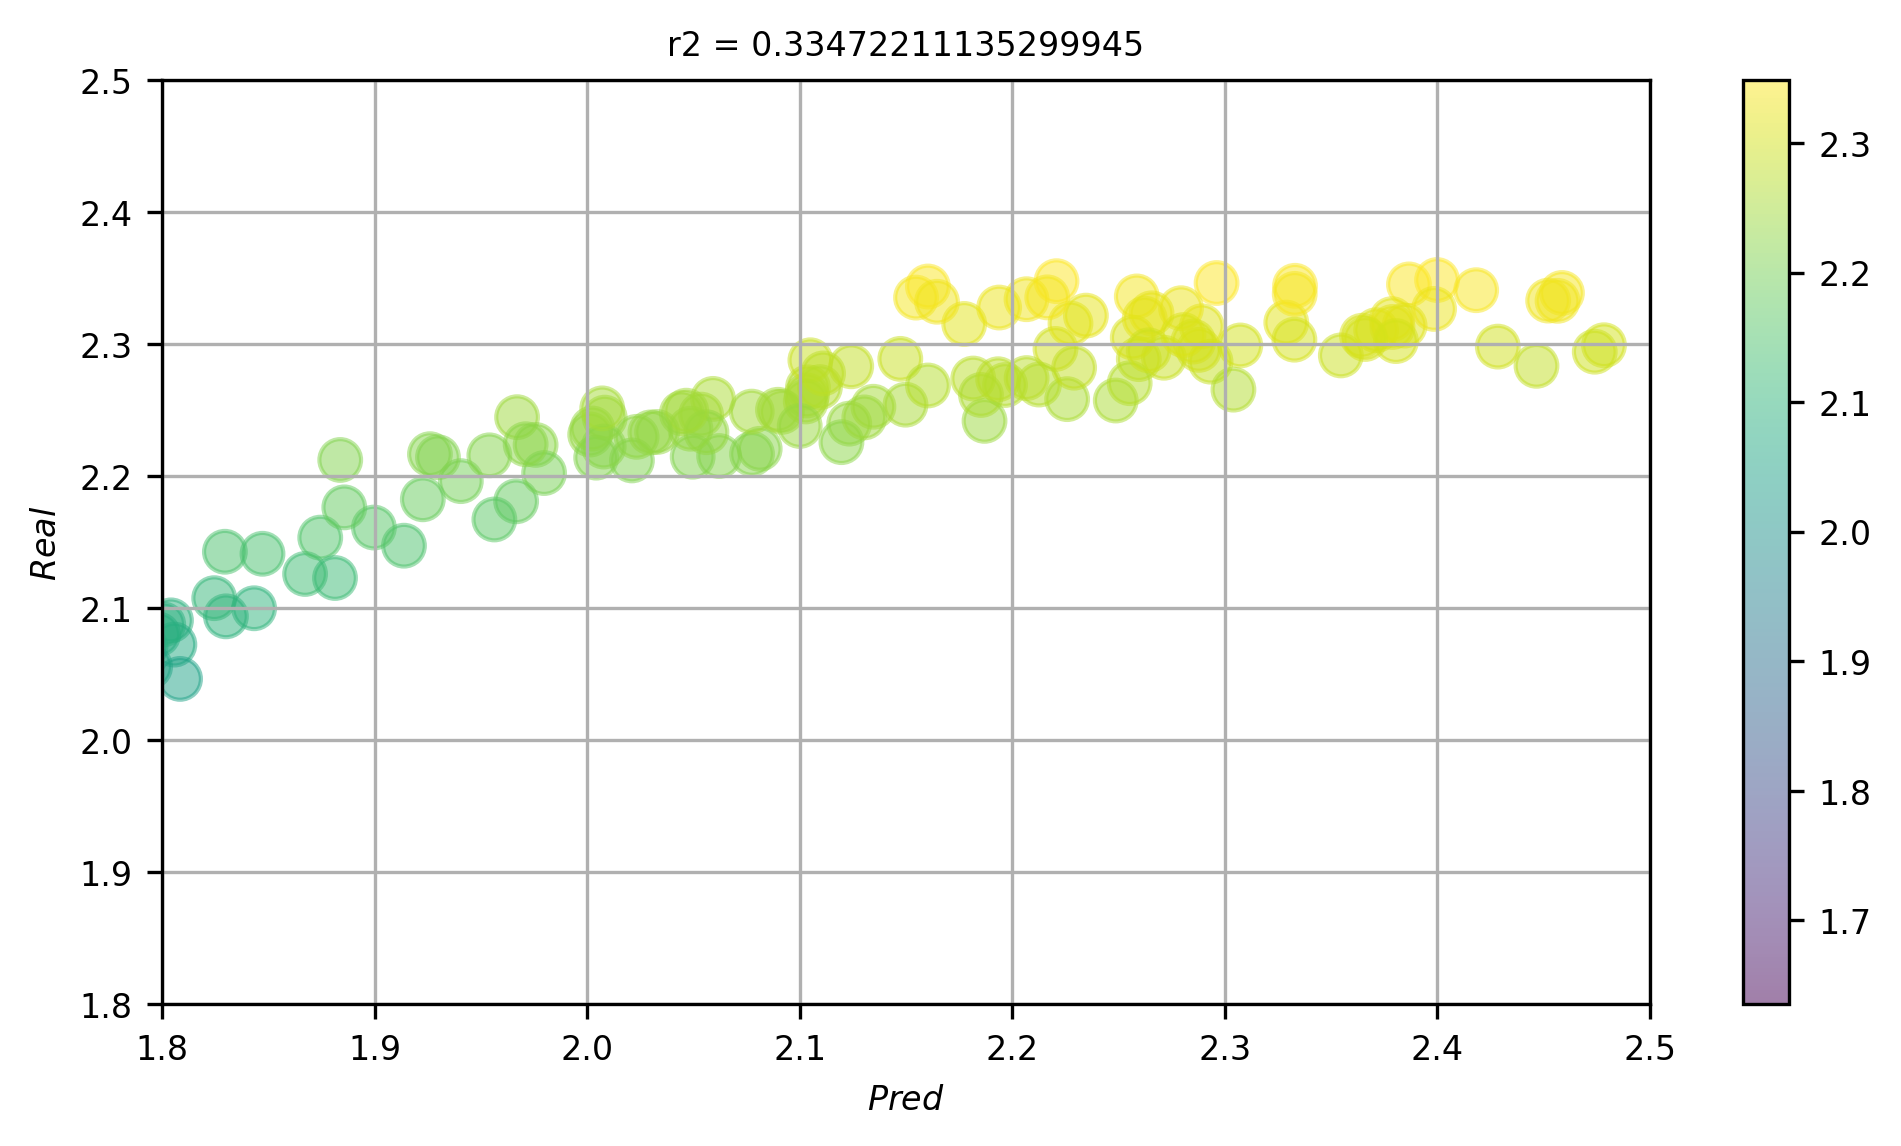

In [52]:

# Plot first and second principal component.

plt.figure(figsize=(8,4),dpi=300)

plt.scatter(pd.DataFrame(y_pred_aux),pd.DataFrame(y_test.values),
            c=y_test, cmap='viridis', alpha=0.5, s=100)
plt.title('r2 = {}'.format(r2_score(y_test, y_pred_aux)))
plt.colorbar()
plt.ylabel(r'$Real$')
plt.xlabel(r'$Pred$')
plt.xlim(1.8,2.5)
plt.ylim(1.8,2.5)
plt.grid()

plt.show()

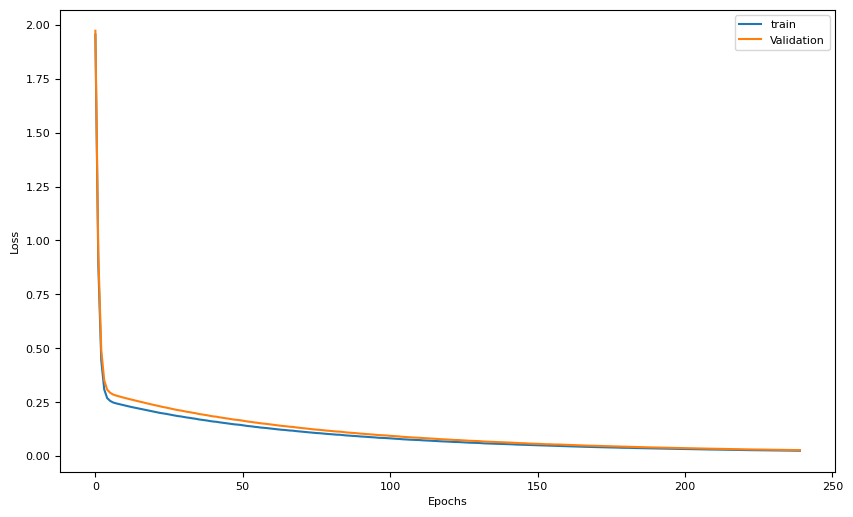

In [53]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
#plt.xlim(80,100)
ax.legend()
plt.show()

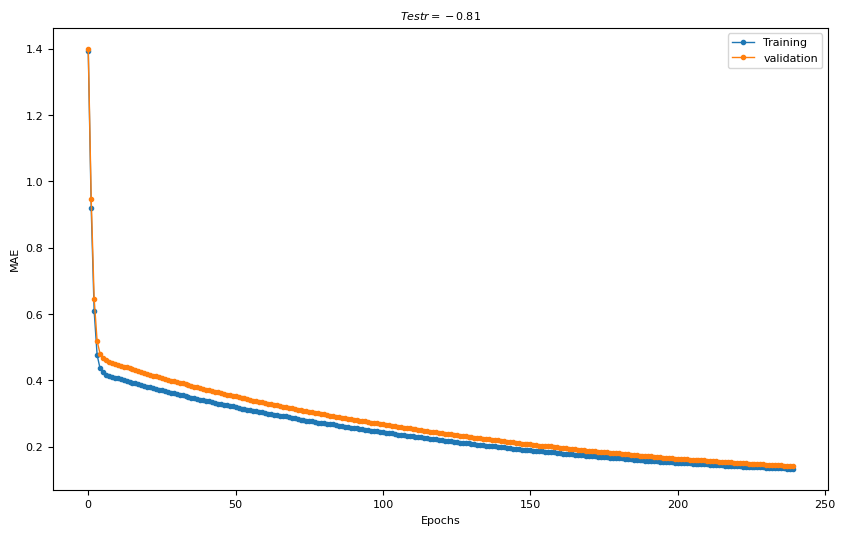

In [54]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['mae_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['mae_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('MAE')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['mae_test'])), metrics['mae_test'])[0][1]))
ax.legend()
#plt.ylim(0,3)
plt.show()

## Testing on experimental data

In [17]:
from nilearn import datasets

abide = datasets.fetch_abide_pcp(data_dir='/Users/rodrigo/Post-Grad/Ising_GNN')


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/nilearn/datasets/func.py:1019: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


Resuming failed, try to download the whole file.


Downloaded 176332800 of 179385641 bytes (98.3%,    0.8s remaining) ...done. (45 seconds, 0 min)


Downloaded 176414720 of 177744953 bytes (99.3%,    0.4s remaining) ...done. (50 seconds, 0 min)


Downloaded 176988160 of 179464905 bytes (98.6%,    0.6s remaining) ...done. (46 seconds, 0 min)


Downloaded 172244992 of 173896811 bytes (99.1%,    0.5s remaining) ...done. (52 seconds, 0 min)


Downloaded 174227456 of 177057224 bytes (98.4%,    0.7s remaining) ...done. (45 seconds, 0 min)


Downloaded 170434560 of 173726573 bytes (98.1%,    0.8s remaining) ...done. (43 seconds, 0 min)


Downloaded 165748736 of 165926067 bytes (99.9%,    0.1s remaining) ...done. (58 seconds, 0 min)


Downloaded 168468480 of 172719519 bytes (97.5%,    1.3s remaining) ...done. (54 seconds, 0 min)


Downloaded 169082880 of 169561738 bytes (99.7%,    0.1s remaining) ...done. (50 seconds, 0 min)


Downloaded 178528256 of 185185275 bytes (96.4%,    2.5s remaining) ...done. (68 seconds, 1 min)


Downloaded 167665664 of 169029807 bytes (99.2%,    0.4s remaining) ...done. (49 seconds, 0 min)


Downloaded 175628288 of 179041172 bytes (98.1%,    1.0s remaining) ...done. (53 seconds, 0 min)


Downloaded 140206080 of 140445735 bytes (99.8%,    0.1s remaining) ...done. (36 seconds, 0 min)


Downloaded 130244608 of 133502893 bytes (97.6%,    1.2s remaining) ...done. (48 seconds, 0 min)


Downloaded 139001856 of 139285007 bytes (99.8%,    0.2s remaining) ...done. (86 seconds, 1 min)


Downloaded 148226048 of 150281654 bytes (98.6%,    1.0s remaining) ...done. (70 seconds, 1 min)


Downloaded 143753216 of 144407349 bytes (99.5%,    0.1s remaining) ...done. (33 seconds, 0 min)


Downloaded 136716288 of 139918220 bytes (97.7%,    0.9s remaining) ...done. (38 seconds, 0 min)


Downloaded 134561792 of 136104861 bytes (98.9%,    0.4s remaining) ...done. (39 seconds, 0 min)


Downloaded 140189696 of 142229599 bytes (98.6%,    0.5s remaining) ...done. (39 seconds, 0 min)


Downloaded 138797056 of 138860063 bytes (100.0%,    0.0s remaining) ...done. (44 seconds, 0 min)


Downloaded 139304960 of 140308694 bytes (99.3%,    0.3s remaining) ...done. (46 seconds, 0 min)


Downloaded 131457024 of 132698868 bytes (99.1%,    0.4s remaining) ...done. (46 seconds, 0 min)


Downloaded 136724480 of 137363645 bytes (99.5%,    0.3s remaining) ...done. (71 seconds, 1 min)


Downloaded 135127040 of 135690435 bytes (99.6%,    0.2s remaining) ...done. (50 seconds, 0 min)


Downloaded 132857856 of 136299815 bytes (97.5%,    1.4s remaining) ...done. (55 seconds, 0 min)


Downloaded 143679488 of 143696232 bytes (100.0%,    0.0s remaining) ...done. (86 seconds, 1 min)


Downloaded 152100864 of 152354449 bytes (99.8%,    0.2s remaining) ...done. (136 seconds, 2 min)


Downloaded 137961472 of 139930173 bytes (98.6%,    0.7s remaining) ...done. (52 seconds, 0 min)


Downloaded 155238400 of 155946302 bytes (99.5%,    0.4s remaining) ...done. (94 seconds, 1 min)


Downloaded 138035200 of 139492072 bytes (99.0%,    0.3s remaining) ...done. (27 seconds, 0 min)


Downloaded 141860864 of 143261250 bytes (99.0%,    0.8s remaining) ...done. (78 seconds, 1 min)


Downloaded 137207808 of 137895620 bytes (99.5%,    0.3s remaining) ...done. (69 seconds, 1 min)


Downloaded 131416064 of 133422609 bytes (98.5%,    1.2s remaining) ...done. (83 seconds, 1 min)


Downloaded 137068544 of 137157327 bytes (99.9%,    0.0s remaining) ...done. (47 seconds, 0 min)


Downloaded 146300928 of 147253098 bytes (99.4%,    0.2s remaining) ...done. (37 seconds, 0 min)


Downloaded 138862592 of 140445001 bytes (98.9%,    0.3s remaining) ...done. (32 seconds, 0 min)


Downloaded 135225344 of 137483496 bytes (98.4%,    0.5s remaining) ...done. (31 seconds, 0 min)


Downloaded 127754240 of 130721576 bytes (97.7%,    0.9s remaining) ...done. (40 seconds, 0 min)


Downloaded 134668288 of 137559064 bytes (97.9%,    0.8s remaining) ...done. (39 seconds, 0 min)


Downloaded 136052736 of 138490381 bytes (98.2%,    1.1s remaining) ...done. (64 seconds, 1 min)


Downloaded 136478720 of 139265147 bytes (98.0%,    0.9s remaining) ...done. (44 seconds, 0 min)


Downloaded 138919936 of 141492763 bytes (98.2%,    0.9s remaining) ...done. (48 seconds, 0 min)


Downloaded 136667136 of 139601792 bytes (97.9%,    0.9s remaining) ...done. (43 seconds, 0 min)


Downloaded 130285568 of 133993946 bytes (97.2%,    1.3s remaining) ...done. (48 seconds, 0 min)


Downloaded 125689856 of 129501596 bytes (97.1%,    1.0s remaining) ...done. (35 seconds, 0 min)


Downloaded 134463488 of 135509935 bytes (99.2%,    0.3s remaining) ...done. (43 seconds, 0 min)


Downloaded 133160960 of 134193929 bytes (99.2%,    0.3s remaining) ...done. (43 seconds, 0 min)


Downloaded 136413184 of 136959320 bytes (99.6%,    0.1s remaining) ...done. (38 seconds, 0 min)


Downloaded 126812160 of 131538383 bytes (96.4%,    1.2s remaining) ...done. (34 seconds, 0 min)


Downloaded 133529600 of 134268028 bytes (99.5%,    0.3s remaining) ...done. (54 seconds, 0 min)


Downloaded 139075584 of 139985417 bytes (99.4%,    0.3s remaining) ...done. (52 seconds, 0 min)


Downloaded 133283840 of 135763780 bytes (98.2%,    0.9s remaining) ...done. (50 seconds, 0 min)


Downloaded 139706368 of 140503474 bytes (99.4%,    0.4s remaining) ...done. (78 seconds, 1 min)


Downloaded 132513792 of 132995013 bytes (99.6%,    0.1s remaining) ...done. (40 seconds, 0 min)


Downloaded 136650752 of 138762617 bytes (98.5%,    0.8s remaining) ...done. (54 seconds, 0 min)


Downloaded 132366336 of 133258192 bytes (99.3%,    0.2s remaining) ...done. (33 seconds, 0 min)


Downloaded 138993664 of 139599195 bytes (99.6%,    0.2s remaining) ...done. (37 seconds, 0 min)


Downloaded 130170880 of 134074386 bytes (97.1%,    0.9s remaining) ...done. (31 seconds, 0 min)


Downloaded 136159232 of 138237154 bytes (98.5%,    0.4s remaining) ...done. (29 seconds, 0 min)


Downloaded 129302528 of 132076598 bytes (97.9%,    1.3s remaining) ...done. (62 seconds, 1 min)


Downloaded 132939776 of 136362024 bytes (97.5%,    1.5s remaining) ...done. (61 seconds, 1 min)


Downloaded 138870784 of 140042608 bytes (99.2%,    0.4s remaining) ...done. (52 seconds, 0 min)


Downloaded 141828096 of 145273888 bytes (97.6%,    1.0s remaining) ...done. (41 seconds, 0 min)


Downloaded 133496832 of 135076421 bytes (98.8%,    0.7s remaining) ...done. (61 seconds, 1 min)


Downloaded 135921664 of 138494302 bytes (98.1%,    0.9s remaining) ...done. (50 seconds, 0 min)


Downloaded 133029888 of 136796649 bytes (97.2%,    1.0s remaining) ...done. (38 seconds, 0 min)


Downloaded 132800512 of 134447301 bytes (98.8%,    0.6s remaining) ...done. (47 seconds, 0 min)


Downloaded 137904128 of 139056644 bytes (99.2%,    0.3s remaining) ...done. (37 seconds, 0 min)


Downloaded 142778368 of 146948347 bytes (97.2%,    1.3s remaining) ...done. (46 seconds, 0 min)


Downloaded 131555328 of 137508548 bytes (95.7%,    1.2s remaining) ...done. (29 seconds, 0 min)


Downloaded 137314304 of 139233353 bytes (98.6%,    0.4s remaining) ...done. (30 seconds, 0 min)


Downloaded 131514368 of 132307173 bytes (99.4%,    0.4s remaining) ...done. (67 seconds, 1 min)


Downloaded 137863168 of 139633718 bytes (98.7%,    0.9s remaining) ...done. (69 seconds, 1 min)


Downloaded 139673600 of 142811992 bytes (97.8%,    1.1s remaining) ...done. (51 seconds, 0 min)


Downloaded 131194880 of 132703376 bytes (98.9%,    0.5s remaining) ...done. (48 seconds, 0 min)


Downloaded 135200768 of 136772955 bytes (98.9%,    0.4s remaining) ...done. (39 seconds, 0 min)


Downloaded 137232384 of 138518473 bytes (99.1%,    0.3s remaining) ...done. (33 seconds, 0 min)


Downloaded 143147008 of 144950049 bytes (98.8%,    0.5s remaining) ...done. (43 seconds, 0 min)


Downloaded 120135680 of 120171179 bytes (100.0%,    0.0s remaining) ...done. (41 seconds, 0 min)


Downloaded 114515968 of 117156273 bytes (97.7%,    0.6s remaining) ...done. (28 seconds, 0 min)


Downloaded 120291328 of 121087221 bytes (99.3%,    0.2s remaining) ...done. (29 seconds, 0 min)


Downloaded 113745920 of 117103366 bytes (97.1%,    0.9s remaining) ...done. (31 seconds, 0 min)


Downloaded 115654656 of 116631542 bytes (99.2%,    0.3s remaining) ...done. (36 seconds, 0 min)


Downloaded 114425856 of 114814661 bytes (99.7%,    0.2s remaining) ...done. (49 seconds, 0 min)


Downloaded 123240448 of 124761782 bytes (98.8%,    0.7s remaining) ...done. (56 seconds, 0 min)


Downloaded 126787584 of 129519697 bytes (97.9%,    0.8s remaining) ...done. (39 seconds, 0 min)


Downloaded 118767616 of 120868445 bytes (98.3%,    0.4s remaining) ...done. (25 seconds, 0 min)


Downloaded 122748928 of 123230298 bytes (99.6%,    0.1s remaining) ...done. (38 seconds, 0 min)


Downloaded 116752384 of 119348832 bytes (97.8%,    0.7s remaining) ...done. (31 seconds, 0 min)


Downloaded 122052608 of 124458048 bytes (98.1%,    0.8s remaining) ...done. (44 seconds, 0 min)


Downloaded 122585088 of 122948334 bytes (99.7%,    0.1s remaining) ...done. (39 seconds, 0 min)


Downloaded 122822656 of 123440333 bytes (99.5%,    0.1s remaining) ...done. (26 seconds, 0 min)


Downloaded 126631936 of 127251738 bytes (99.5%,    0.2s remaining) ...done. (40 seconds, 0 min)


Downloaded 119447552 of 122188442 bytes (97.8%,    1.2s remaining) ...done. (53 seconds, 0 min)


Downloaded 129392640 of 132363471 bytes (97.8%,    0.9s remaining) ...done. (40 seconds, 0 min)


Downloaded 114114560 of 118643491 bytes (96.2%,    0.9s remaining) ...done. (25 seconds, 0 min)


Downloaded 114311168 of 118562278 bytes (96.4%,    1.4s remaining) ...done. (40 seconds, 0 min)


Downloaded 120324096 of 121285900 bytes (99.2%,    0.4s remaining) ...done. (56 seconds, 0 min)


Downloaded 123994112 of 125119187 bytes (99.1%,    0.8s remaining) ...done. (85 seconds, 1 min)


Downloaded 120356864 of 124096742 bytes (97.0%,    1.0s remaining) ...done. (35 seconds, 0 min)


Downloaded 112402432 of 112783960 bytes (99.7%,    0.3s remaining) ...done. (77 seconds, 1 min)


Downloaded 114319360 of 114477563 bytes (99.9%,    0.2s remaining) ...done. (133 seconds, 2 min)


Downloaded 119193600 of 121472583 bytes (98.1%,    0.6s remaining) ...done. (32 seconds, 0 min)


Downloaded 104169472 of 106373800 bytes (97.9%,    0.8s remaining) ...done. (40 seconds, 0 min)


Downloaded 120905728 of 122335851 bytes (98.8%,    0.8s remaining) ...done. (71 seconds, 1 min)


Downloaded 124657664 of 126737583 bytes (98.4%,    1.9s remaining) ...done. (118 seconds, 1 min)


Downloaded 123019264 of 123096512 bytes (99.9%,    0.0s remaining) ...done. (70 seconds, 1 min)


Downloaded 126394368 of 126777465 bytes (99.7%,    0.2s remaining) ...done. (55 seconds, 0 min)


Downloaded 122675200 of 122845365 bytes (99.9%,    0.1s remaining) ...done. (88 seconds, 1 min)


Downloaded 116981760 of 119513741 bytes (97.9%,    0.7s remaining) ...done. (36 seconds, 0 min)


Downloaded 123404288 of 124089636 bytes (99.4%,    0.4s remaining) ...done. (83 seconds, 1 min)


Downloaded 120020992 of 121313316 bytes (98.9%,    0.4s remaining) ...done. (41 seconds, 0 min)


Downloaded 120569856 of 123446223 bytes (97.7%,    1.5s remaining) ...done. (66 seconds, 1 min)


Downloaded 119914496 of 120376102 bytes (99.6%,    0.2s remaining) ...done. (48 seconds, 0 min)


Downloaded 120733696 of 121896937 bytes (99.0%,    0.6s remaining) ...done. (60 seconds, 0 min)


Downloaded 129744896 of 132645118 bytes (97.8%,    0.6s remaining) ...done. (29 seconds, 0 min)


Downloaded 127082496 of 128778417 bytes (98.7%,    0.5s remaining) ...done. (42 seconds, 0 min)


Downloaded 124002304 of 124095222 bytes (99.9%,    0.1s remaining) ...done. (132 seconds, 2 min)


Downloaded 124510208 of 124557732 bytes (100.0%,    0.0s remaining) ...done. (79 seconds, 1 min)


Downloaded 138108928 of 138163816 bytes (100.0%,    0.0s remaining) ...done. (42 seconds, 0 min)


Downloaded 160317440 of 161351783 bytes (99.4%,    0.2s remaining) ...done. (35 seconds, 0 min)


Downloaded 121184256 of 121759875 bytes (99.5%,    0.2s remaining) ...done. (33 seconds, 0 min)


Downloaded 162963456 of 164600761 bytes (99.0%,    1.1s remaining) ...done. (113 seconds, 1 min)


Downloaded 130637824 of 133481851 bytes (97.9%,    0.9s remaining) ...done. (42 seconds, 0 min)


Downloaded 131284992 of 133842077 bytes (98.1%,    0.9s remaining) ...done. (47 seconds, 0 min)


Downloaded 132440064 of 135317099 bytes (97.9%,    0.9s remaining) ...done. (42 seconds, 0 min)


Downloaded 134275072 of 136666507 bytes (98.3%,    1.6s remaining) ...done. (89 seconds, 1 min)


Downloaded 136833786 of 136833786 bytes (100.0%,    0.0s remaining) ...done. (55 seconds, 0 min)


Downloaded 134422528 of 136410147 bytes (98.5%,    1.4s remaining) ...done. (97 seconds, 1 min)


Downloaded 160268288 of 160720117 bytes (99.7%,    0.3s remaining) ...done. (124 seconds, 2 min)


Downloaded 134594560 of 134668855 bytes (99.9%,    0.1s remaining) ...done. (103 seconds, 1 min)


Downloaded 132767744 of 133657832 bytes (99.3%,    0.6s remaining) ...done. (86 seconds, 1 min)


Downloaded 138805248 of 140812159 bytes (98.6%,    0.7s remaining) ...done. (48 seconds, 0 min)


Downloaded 134021120 of 134906172 bytes (99.3%,    0.3s remaining) ...done. (52 seconds, 0 min)


Downloaded 144080896 of 144867083 bytes (99.5%,    0.2s remaining) ...done. (41 seconds, 0 min)


Downloaded 136568832 of 140057549 bytes (97.5%,    1.0s remaining) ...done. (41 seconds, 0 min)


Downloaded 137723904 of 138469680 bytes (99.5%,    0.3s remaining) ...done. (53 seconds, 0 min)


Downloaded 135290880 of 135331517 bytes (100.0%,    0.0s remaining) ...done. (77 seconds, 1 min)


Downloaded 135790592 of 136489599 bytes (99.5%,    0.2s remaining) ...done. (46 seconds, 0 min)


Downloaded 143826944 of 144289675 bytes (99.7%,    0.2s remaining) ...done. (77 seconds, 1 min)


Downloaded 140836864 of 141849310 bytes (99.3%,    0.4s remaining) ...done. (63 seconds, 1 min)


Downloaded 138362880 of 140019413 bytes (98.8%,    0.6s remaining) ...done. (51 seconds, 0 min)


Downloaded 143974400 of 144927164 bytes (99.3%,    0.3s remaining) ...done. (46 seconds, 0 min)


Downloaded 131391488 of 135293386 bytes (97.1%,    1.1s remaining) ...done. (39 seconds, 0 min)


Downloaded 139239424 of 140867705 bytes (98.8%,    0.9s remaining) ...done. (82 seconds, 1 min)


Downloaded 135217152 of 137065207 bytes (98.7%,    0.6s remaining) ...done. (42 seconds, 0 min)


Downloaded 135397376 of 137573783 bytes (98.4%,    0.6s remaining) ...done. (42 seconds, 0 min)


Downloaded 140599296 of 142408850 bytes (98.7%,    0.8s remaining) ...done. (66 seconds, 1 min)


Downloaded 140427264 of 141840973 bytes (99.0%,    0.3s remaining) ...done. (32 seconds, 0 min)


Downloaded 139083776 of 141020130 bytes (98.6%,    0.7s remaining) ...done. (55 seconds, 0 min)


Downloaded 142917632 of 143049887 bytes (99.9%,    0.0s remaining) ...done. (33 seconds, 0 min)


Downloaded 136437760 of 138631692 bytes (98.4%,    0.6s remaining) ...done. (42 seconds, 0 min)


Downloaded 139681792 of 140867157 bytes (99.2%,    0.3s remaining) ...done. (42 seconds, 0 min)


Downloaded 139829248 of 140343403 bytes (99.6%,    0.2s remaining) ...done. (48 seconds, 0 min)


Downloaded 130940928 of 134010080 bytes (97.7%,    0.9s remaining) ...done. (41 seconds, 0 min)


Downloaded 139026432 of 139081019 bytes (100.0%,    0.0s remaining) ...done. (42 seconds, 0 min)


Downloaded 135094272 of 137717465 bytes (98.1%,    0.9s remaining) ...done. (47 seconds, 0 min)


Downloaded 138805248 of 138844870 bytes (100.0%,    0.0s remaining) ...done. (41 seconds, 0 min)


Downloaded 134234112 of 138395758 bytes (97.0%,    0.9s remaining) ...done. (32 seconds, 0 min)


Downloaded 146178048 of 149240568 bytes (97.9%,    0.8s remaining) ...done. (43 seconds, 0 min)


Downloaded 135798784 of 138380386 bytes (98.1%,    0.8s remaining) ...done. (45 seconds, 0 min)


Downloaded 138797056 of 139304315 bytes (99.6%,    0.2s remaining) ...done. (50 seconds, 0 min)


Downloaded 133210112 of 133859296 bytes (99.5%,    0.1s remaining) ...done. (30 seconds, 0 min)


Downloaded 130039808 of 131984425 bytes (98.5%,    0.5s remaining) ...done. (36 seconds, 0 min)


Downloaded 144408576 of 146804453 bytes (98.4%,    0.6s remaining) ...done. (41 seconds, 0 min)


Downloaded 130482176 of 130757814 bytes (99.8%,    0.1s remaining) ...done. (36 seconds, 0 min)


Downloaded 139632640 of 140631052 bytes (99.3%,    0.5s remaining) ...done. (73 seconds, 1 min)


Downloaded 142630912 of 143901592 bytes (99.1%,    0.3s remaining) ...done. (37 seconds, 0 min)


Downloaded 135094272 of 137365911 bytes (98.3%,    0.7s remaining) ...done. (43 seconds, 0 min)


Downloaded 143171584 of 145894375 bytes (98.1%,    0.8s remaining) ...done. (44 seconds, 0 min)


Downloaded 140500992 of 142471670 bytes (98.6%,    0.8s remaining) ...done. (63 seconds, 1 min)


Downloaded 139886592 of 140948682 bytes (99.2%,    0.4s remaining) ...done. (60 seconds, 1 min)


Downloaded 133718016 of 138022155 bytes (96.9%,    2.7s remaining) ...done. (86 seconds, 1 min)


Downloaded 134422528 of 137389059 bytes (97.8%,    0.8s remaining) ...done. (39 seconds, 0 min)


Downloaded 144277504 of 145736743 bytes (99.0%,    0.5s remaining) ...done. (46 seconds, 0 min)


Downloaded 136691712 of 137902964 bytes (99.1%,    0.5s remaining) ...done. (64 seconds, 1 min)


Downloaded 141565952 of 146712794 bytes (96.5%,    1.1s remaining) ...done. (32 seconds, 0 min)


Downloaded 149315584 of 149565752 bytes (99.8%,    0.1s remaining) ...done. (50 seconds, 0 min)


Downloaded 137166848 of 138254316 bytes (99.2%,    0.4s remaining) ...done. (49 seconds, 0 min)


Downloaded 128008192 of 133481454 bytes (95.9%,    2.3s remaining) ...done. (55 seconds, 0 min)


Downloaded 146604032 of 147993926 bytes (99.1%,    0.5s remaining) ...done. (55 seconds, 0 min)


Downloaded 138838016 of 139907953 bytes (99.2%,    1.1s remaining) ...done. (142 seconds, 2 min)


Downloaded 138641408 of 141403797 bytes (98.0%,    1.8s remaining) ...done. (90 seconds, 1 min)


Downloaded 140779520 of 142498803 bytes (98.8%,    0.8s remaining) ...done. (70 seconds, 1 min)


Downloaded 137519104 of 137913235 bytes (99.7%,    0.2s remaining) ...done. (54 seconds, 0 min)


Downloaded 142155776 of 142231378 bytes (99.9%,    0.2s remaining) ...done. (442 seconds, 7 min)


Downloaded 90767360 of 91238049 bytes (99.5%,    0.3s remaining) ...done. (61 seconds, 1 min)


Downloaded 90832896 of 92064659 bytes (98.7%,    0.3s remaining) ...done. (23 seconds, 0 min)


Downloaded 90857472 of 92883131 bytes (97.8%,    0.8s remaining) ...done. (39 seconds, 0 min)


Downloaded 93937664 of 94022534 bytes (99.9%,    0.1s remaining) ...done. (69 seconds, 1 min)


Downloaded 94814208 of 94917214 bytes (99.9%,    0.0s remaining) ...done. (32 seconds, 0 min)


Downloaded 94715904 of 96135378 bytes (98.5%,    0.8s remaining) ...done. (53 seconds, 0 min)


Downloaded 91971584 of 94388969 bytes (97.4%,    0.6s remaining) ...done. (26 seconds, 0 min)


Downloaded 90636288 of 93142479 bytes (97.3%,    1.2s remaining) ...done. (45 seconds, 0 min)


Downloaded 92217344 of 93099782 bytes (99.1%,    0.4s remaining) ...done. (43 seconds, 0 min)


Downloaded 93216768 of 93773249 bytes (99.4%,    0.1s remaining) ...done. (19 seconds, 0 min)


Downloaded 90587136 of 90664834 bytes (99.9%,    0.0s remaining) ...done. (48 seconds, 0 min)


Downloaded 92135424 of 93519695 bytes (98.5%,    0.8s remaining) ...done. (58 seconds, 0 min)


Downloaded 88588288 of 89349808 bytes (99.1%,    0.4s remaining) ...done. (52 seconds, 0 min)


Downloaded 75661312 of 78254520 bytes (96.7%,    0.8s remaining) ...done. (24 seconds, 0 min)


Downloaded 69853184 of 74093738 bytes (94.3%,    1.7s remaining) ...done. (30 seconds, 0 min)


Downloaded 89800704 of 90461060 bytes (99.3%,    0.4s remaining) ...done. (61 seconds, 1 min)


Downloaded 91488256 of 92227326 bytes (99.2%,    0.6s remaining) ...done. (71 seconds, 1 min)


Downloaded 91439104 of 94363131 bytes (96.9%,    2.2s remaining) ...done. (70 seconds, 1 min)


Downloaded 86540288 of 89533445 bytes (96.7%,    0.9s remaining) ...done. (28 seconds, 0 min)


Downloaded 91725824 of 93358766 bytes (98.3%,    0.8s remaining) ...done. (47 seconds, 0 min)


Downloaded 96821248 of 97708115 bytes (99.1%,    0.3s remaining) ...done. (36 seconds, 0 min)


Downloaded 93233152 of 93718004 bytes (99.5%,    0.2s remaining) ...done. (45 seconds, 0 min)


Downloaded 88268800 of 90726692 bytes (97.3%,    0.8s remaining) ...done. (32 seconds, 0 min)


Downloaded 91635712 of 95459566 bytes (96.0%,    0.9s remaining) ...done. (22 seconds, 0 min)


Downloaded 92643328 of 93677735 bytes (98.9%,    0.2s remaining) ...done. (22 seconds, 0 min)


Downloaded 75792384 of 76052652 bytes (99.7%,    0.1s remaining) ...done. (34 seconds, 0 min)


Downloaded 78389248 of 78410759 bytes (100.0%,    0.0s remaining) ...done. (25 seconds, 0 min)


Downloaded 100057088 of 102284657 bytes (97.8%,    1.2s remaining) ...done. (54 seconds, 0 min)


Downloaded 91103232 of 93919152 bytes (97.0%,    1.0s remaining) ...done. (33 seconds, 0 min)


Downloaded 95338496 of 95655193 bytes (99.7%,    0.2s remaining) ...done. (61 seconds, 1 min)


Downloaded 89448448 of 89574829 bytes (99.9%,    0.0s remaining) ...done. (34 seconds, 0 min)


Downloaded 90636288 of 91067950 bytes (99.5%,    0.1s remaining) ...done. (32 seconds, 0 min)


Downloaded 89309184 of 90976502 bytes (98.2%,    0.5s remaining) ...done. (28 seconds, 0 min)


Downloaded 106160128 of 107440893 bytes (98.8%,    0.3s remaining) ...done. (26 seconds, 0 min)


Downloaded 95813632 of 96773241 bytes (99.0%,    0.3s remaining) ...done. (36 seconds, 0 min)


Downloaded 102031360 of 103892284 bytes (98.2%,    0.8s remaining) ...done. (46 seconds, 0 min)


Downloaded 105078784 of 105458974 bytes (99.6%,    0.2s remaining) ...done. (59 seconds, 0 min)


Downloaded 98107392 of 98717272 bytes (99.4%,    0.3s remaining) ...done. (54 seconds, 0 min)


Downloaded 104333312 of 105931244 bytes (98.5%,    0.5s remaining) ...done. (32 seconds, 0 min)


Downloaded 95387648 of 95771925 bytes (99.6%,    0.4s remaining) ...done. (107 seconds, 1 min)


Downloaded 95920128 of 96607773 bytes (99.3%,    0.3s remaining) ...done. (46 seconds, 0 min)


Downloaded 104808448 of 105186257 bytes (99.6%,    0.3s remaining) ...done. (86 seconds, 1 min)


Downloaded 102645760 of 103362339 bytes (99.3%,    0.5s remaining) ...done. (79 seconds, 1 min)


Downloaded 109002752 of 109605737 bytes (99.4%,    0.2s remaining) ...done. (37 seconds, 0 min)


Downloaded 103858176 of 104647236 bytes (99.2%,    0.5s remaining) ...done. (70 seconds, 1 min)


Downloaded 96575488 of 98072048 bytes (98.5%,    0.6s remaining) ...done. (38 seconds, 0 min)


Downloaded 106373120 of 109552006 bytes (97.1%,    0.8s remaining) ...done. (30 seconds, 0 min)


Downloaded 100614144 of 105973750 bytes (94.9%,    2.0s remaining) ...done. (39 seconds, 0 min)


Downloaded 106946560 of 108748418 bytes (98.3%,    0.7s remaining) ...done. (43 seconds, 0 min)


Downloaded 107634688 of 108357685 bytes (99.3%,    0.3s remaining) ...done. (42 seconds, 0 min)


Downloaded 97361920 of 98718439 bytes (98.6%,    1.0s remaining) ...done. (71 seconds, 1 min)


Downloaded 99155968 of 100974320 bytes (98.2%,    0.6s remaining) ...done. (37 seconds, 0 min)


Downloaded 97198080 of 100409190 bytes (96.8%,    1.0s remaining) ...done. (31 seconds, 0 min)


Downloaded 103792640 of 104074755 bytes (99.7%,    0.1s remaining) ...done. (45 seconds, 0 min)


Downloaded 109780992 of 113260920 bytes (96.9%,    0.8s remaining) ...done. (28 seconds, 0 min)


Downloaded 107978752 of 108360716 bytes (99.6%,    0.1s remaining) ...done. (32 seconds, 0 min)


Downloaded 103792640 of 104736281 bytes (99.1%,    0.3s remaining) ...done. (29 seconds, 0 min)


Downloaded 105218048 of 107319372 bytes (98.0%,    0.6s remaining) ...done. (30 seconds, 0 min)


Downloaded 104890368 of 107005336 bytes (98.0%,    0.6s remaining) ...done. (30 seconds, 0 min)


Downloaded 105381888 of 106804051 bytes (98.7%,    0.7s remaining) ...done. (55 seconds, 0 min)


Downloaded 101752832 of 102612575 bytes (99.2%,    0.3s remaining) ...done. (38 seconds, 0 min)


Downloaded 104833024 of 104888059 bytes (99.9%,    0.0s remaining) ...done. (27 seconds, 0 min)


Downloaded 102817792 of 106798185 bytes (96.3%,    0.8s remaining) ...done. (23 seconds, 0 min)


Downloaded 107233280 of 108919993 bytes (98.5%,    1.1s remaining) ...done. (74 seconds, 1 min)


Downloaded 103120896 of 104270498 bytes (98.9%,    0.7s remaining) ...done. (66 seconds, 1 min)


Downloaded 100843520 of 105646693 bytes (95.5%,    1.2s remaining) ...done. (27 seconds, 0 min)


Downloaded 99016704 of 101156840 bytes (97.9%,    1.2s remaining) ...done. (56 seconds, 0 min)


Downloaded 99254272 of 101859751 bytes (97.4%,    1.0s remaining) ...done. (41 seconds, 0 min)


Downloaded 105537536 of 106652107 bytes (99.0%,    0.3s remaining) ...done. (25 seconds, 0 min)


Downloaded 105709568 of 108495355 bytes (97.4%,    2.0s remaining) ...done. (76 seconds, 1 min)


Downloaded 91496448 of 93798085 bytes (97.5%,    0.6s remaining) ...done. (27 seconds, 0 min)


Downloaded 93822976 of 96993896 bytes (96.7%,    1.2s remaining) ...done. (38 seconds, 0 min)


Downloaded 95977472 of 97583114 bytes (98.4%,    0.5s remaining) ...done. (33 seconds, 0 min)


Downloaded 97312768 of 98221562 bytes (99.1%,    0.3s remaining) ...done. (38 seconds, 0 min)


Downloaded 101171200 of 102234178 bytes (99.0%,    0.5s remaining) ...done. (48 seconds, 0 min)


Downloaded 97935360 of 99318496 bytes (98.6%,    1.1s remaining) ...done. (80 seconds, 1 min)


Downloaded 35471360 of 108363271 bytes (32.7%,   55.1s remaining)Error while fetching file NYU_0051001_func_preproc.nii.gz; dataset fetching aborted.

ConnectionError: HTTPSConnectionPool(host='s3.amazonaws.com', port=443): Read timed out.

/Users/rodrigo/Post-Grad/Ising_GNN/utils.py:347: FutureWarning: The default value of regex will change from True to False in a future version.
  motion['Subject'] = motion['Subject'].str.replace(r'^(0+)', '').fillna('0')


In [78]:
#X_fmri = pd.DataFrame(np.random.normal(0, 0.25, size= (757, 17955)))

In [79]:
#from sklearn.model_selection import train_test_split

# Split train and validation set
#X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95, shuffle=True, random_state=42)

In [80]:
A = reconstruct_symmetric_matrix(190, X_fmri.iloc[:,:].mean(axis=0))

In [81]:
train_data, val_data = create_graph(X_train, X_fmri, y, y,method={'knn_group' : compute_KNN_graph(A, 10)})#, method={'threshold': 0.8})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

In [82]:
y_pred_aux_age = []
for y_i in val_loader:
    y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0]) 


#### Age decrease complexity https://www.frontiersin.org/articles/10.3389/fnins.2020.00700/full

In [83]:
my_dict_age = {}
for i in range(len(y.values)):
    my_dict_age[y.values[i]] = y_pred_aux_age[i]

In [84]:
y = pd.DataFrame(y)
y['y_pred'] = y_pred_aux_age
y = y.dropna()

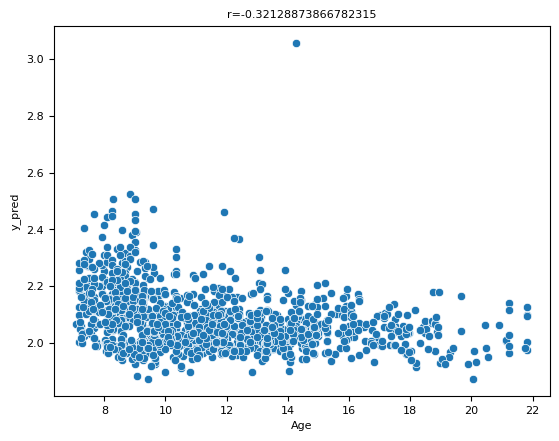

In [85]:
#sns.boxplot(y_test, x='Age', y='y_pred')

#sns.scatterplot(y, x='Max Motion (mm)', y='y_pred') 
#plt.title('r={}'.format(np.corrcoef([y['Max Motion (mm)'].values, y['y_pred'].values])[0,1]))
#plt.title('r={}'.format(r2_score(y_test['Max Motion (mm)'].values, y_test['y_pred'].values)))

sns.scatterplot(y, x='Age', y='y_pred') 
plt.title('r={}'.format(np.corrcoef([y['Age'].values, y['y_pred'].values])[0,1]))
#plt.title('r={}'.format(r2_score(y_test['Age'].values, y_test['y_pred'].values)))

plt.show()

In [86]:
results = merged_df[['Institution','Subject', 'Run']]
results['Age'] = y_pred_aux_age

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_19912/591760499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Age'] = y_pred_aux_age


In [87]:
results.to_csv('DX_012.csv')

### DX

In [ ]:
df_aux = df[df['DX'] == 0]


# Labels
y = (df_aux.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X_fmri = np.tanh(df_aux.iloc[:,:-2])

from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95,
                                                    shuffle=True, random_state=42)

train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

y_pred_aux_0 = []
for y_i in val_loader:
    y_pred_aux_0.append((model(y_i))[1].detach().numpy().ravel()[0]) 


In [ ]:
df_aux = df[df['DX'] == 1]


# Labels
y = (df_aux.Age).apply(lambda x: int(x))

# Remove from Fisher-space
X_fmri = np.tanh(df_aux.iloc[:,:-2])

from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X_fmri,y,test_size=0.95,
                                                    shuffle=True, random_state=42)

train_data, val_data = create_graph(X_train, X_test, y_train, y_test) #,method={'threshold': 0.2})
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

y_pred_aux_1 = []
for y_i in val_loader:
    y_pred_aux_1.append((model(y_i))[1].detach().numpy().ravel()[0]) 


In [ ]:
my_dict = {'1': y_pred_aux_1, '0' : y_pred_aux_0}


In [ ]:
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
#plt.ylim(1.8,2.1)
plt.show()

In [ ]:
X.shape

In [190]:
np.savetxt('Ising_GNN.txt', X.reshape(1200*17955))